<h1>Simulation for Battery Electrolyte Materials Discovery</h1>

This notebook will investigates the pheasibility of executing quantum simulations for different molecules that might be of interest. We plan to analyse the requirements of each candidate as well as running some simple simulations on some of them.

<h2>Necessary Imports</h2>

In [89]:
from qiskit.algorithms import VQE, NumPyMinimumEigensolver, NumPyEigensolver #Algorithms

#Qiskit odds and ends
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP, L_BFGS_B
from qiskit.opflow import Z2Symmetries, X, Y, Z, I, PauliSumOp, Gradient, NaturalGradient
from qiskit import IBMQ, BasicAer, Aer, transpile
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.utils.mitigation import CompleteMeasFitter #Measurement error mitigatioin
from qiskit.tools.visualization import circuit_drawer
from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.algorithms.minimum_eigensolvers import AdaptVQE, MinimumEigensolverResult
from qiskit.primitives import Estimator

#qiskit_nature
from qiskit_nature.second_q.drivers import PySCFDriver, MethodType
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.circuit.library import UCCSD, PUCCD, SUCCD, HartreeFock, CHC, VSCF
from qiskit_nature.second_q.operators.fermionic_op import FermionicOp
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer , FreezeCoreTransformer
from qiskit_nature.second_q.problems import ElectronicStructureProblem, EigenstateResult
from qiskit_nature.second_q.mappers import QubitConverter, ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.second_q.algorithms.ground_state_solvers.minimum_eigensolver_factories.vqe_ucc_factory import VQEUCCFactory
from qiskit_nature.second_q.algorithms.ground_state_solvers.minimum_eigensolver_factories.numpy_minimum_eigensolver_factory import NumPyMinimumEigensolverFactory
from qiskit_nature.second_q.algorithms.ground_state_solvers import GroundStateEigensolver
from qiskit_nature.second_q.algorithms.excited_states_solvers.eigensolver_factories.numpy_eigensolver_factory import NumPyEigensolverFactory
from qiskit_nature.second_q.algorithms.excited_states_solvers import QEOM, ExcitedStatesEigensolver

#Runtime
from qiskit_ibm_runtime import (QiskitRuntimeService, Session,
                                Estimator as RuntimeEstimator)
from qiskit_ibm_runtime.options import Options, ResilienceOptions, SimulatorOptions, TranspilationOptions

#Python odds and ends
import matplotlib
import matplotlib.pyplot as plt
import matplotlib
import pylab
import numpy as np
import os
import pyscf
from IPython.display import display, clear_output
import mapomatic as mm

from datetime import datetime
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

IBMQ.load_account()
provider = IBMQ.get_provider(group='deployed')
service = QiskitRuntimeService(channel='ibm_quantum')
#set Backends
#simulators
backend_stv = Aer.get_backend('aer_simulator_statevector')
#Real Devices
backend_nair= provider.get_backend('ibm_nairobi')
backend_manil = provider.get_backend('ibmq_manila')
backend_qsm_ibm=provider.get_backend('ibmq_qasm_simulator')

sh=1024 #shots

#solvers
npme = NumPyMinimumEigensolver()
npe=NumPyEigensolver()

ibmqfactory.load_account:WARNING:2023-01-11 16:17:10,478: Credentials are already in use. The existing account in the session will be replaced.


In [2]:
## Python program to store list to file using pickle module
import pickle

# write list to binary file
def write_list(a_list,filename):
    # store list in binary file so 'wb' mode
    with open(filename, 'wb') as fp:
        pickle.dump(a_list, fp)
        print('Done writing list into a binary file')
        
def write_dict(a_dict,filename):
    # store list in binary file so 'wb' mode
    with open(filename, 'wb') as fp:
        pickle.dump(a_dict, fp,protocol=pickle.HIGHEST_PROTOCOL)
        print('Done writing dict into a binary file')

# Read list to memory
def read(filename):
    # for reading also binary mode is important
    with open(filename, 'rb') as fp:
        n_list = pickle.load(fp)
        return n_list

In [129]:
#Create a custoom VQE Program
from qiskit.algorithms.minimum_eigensolvers import MinimumEigensolver, VQEResult

class CustomVQE(MinimumEigensolver):
    
    def __init__(self, estimator, circuit, optimizer, callback=None):
        self._estimator = estimator
        self._circuit = circuit
        self._optimizer = optimizer
        self._callback = callback
        self._eval_count=0
        
    def compute_minimum_eigenvalue(self, operators,initial_point, aux_operators=None):
                
        # Define objective function to classically minimize over
        def objective(x):
            # Execute job with estimator primitive
            job = self._estimator.run([self._circuit], [operators], [x])
            # Get results from jobs
            est_result = job.result()
            # Get the measured energy value
            value = est_result.values[0]
            std=est_result.metadata[0]
            self._eval_count+=1
            # Save result information using callback function
            if self._callback is not None:
                self._callback(self._eval_count, value, std)
            return value    
        # Select an initial point for the ansatzs' parameters
        x0 =initial_point
        #x0=0*np.random.rand(self._circuit.num_parameters)
        
        # Run optimization
        res = self._optimizer.minimize(objective, x0=x0)
        
        # Populate VQE result
        result = VQEResult()
        result.cost_function_evals = res.nfev
        result.eigenvalue = res.fun
        result.optimal_parameters = res.x
        return result

counts = []
values = []
deviation = []
def callback(eval_count, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    deviation.append(std)
    
counts_sim = []
values_sim = []
deviation_sim = []
def callback_sim(eval_count, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts_sim.append(eval_count)
    values_sim.append(mean)
    deviation_sim.append(std)
    
counts_real = []
values_real = []
deviation_real = []
def callback_real(eval_count, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts_real.append(eval_count)
    values_real.append(mean)
    deviation_real.append(std)


<h2>Candidates</h2>

* O2
* I2
* LiI
* C4H10O2
* Li2O
* LiF
* Li3N
* LiCL


<h2>O2</h2>

First thing is to define the molecule, get the Hamiltonian and map it to a qubit ooperator.

In [2]:
#Define Molecule
molecule = Molecule(
             # coordinates in Angstrom
                    geometry=[
                            ["O", [1.2075 ,0.0 ,0.0]],
                            ["O", [0.0 ,0.0,0.0]]
                            ],
                     multiplicity=1,  # = 2*spin + 1
                     charge=0
                    )
    
#Set driver
driver = ElectronicStructureMoleculeDriver(
    molecule=molecule,
    basis="sto3g",
    driver_type=ElectronicStructureDriverType.PYSCF,
    )

#Get properties
properties = driver.run()
    
#particle_number = problem.grouped_property_transformed.get_property("ParticleNumber")
num_a_electrons = properties.get_property("ParticleNumber").num_alpha
num_b_electrons = properties.get_property("ParticleNumber").num_beta
num_particles=properties.get_property("ParticleNumber").num_particles

num_spin_orbitals =int(properties.get_property("ParticleNumber").num_spin_orbitals)

rep_energy = properties.get_property("ElectronicEnergy").nuclear_repulsion_energy
    
# Check the occupation of the spin orbitals
PN_property = properties.get_property("ParticleNumber")

# Define the active space
# (selected automatically around the HOMO and LUMO, ordered by energy)
transformer = ActiveSpaceTransformer(
    num_electrons=(8,8), #Electrons in active space
    num_molecular_orbitals=9 #Orbitals in active space
    #,active_orbitals=np.arange(1,11,1)
)
    
#Define the problem

problem = ElectronicStructureProblem(driver)
    
second_q_ops = problem.second_q_ops() # Get 2nd Quant OP. This calls driver.run() internally
    
num_spin_orbitals = problem.num_spin_orbitals
num_particles = problem.num_particles
    
hamiltonian = second_q_ops[0] #Set Hamiltonian
mapper=ParityMapper()

#Get Pauli OP
#converter = QubitConverter(mapper)
#qubit_op = converter.convert(hamiltonian)
    
#Symmetries
#sym=Z2Symmetries.find_Z2_symmetries(qubit_op)

converter = QubitConverter(mapper)
    
#Final OP
#qubit_op = converter.convert(hamiltonian,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)

Now let's see how many qubits are necessary:

In [5]:
qubit_op.num_qubits

20

We have some strategies to lower this number. But before we do that let's take a look at our molecule

In [14]:
print(properties)

ElectronicStructureDriverResult:
	DriverMetadata:
		Program: PYSCF
		Version: 2.0.1
		Config:
			atom=O 1.2075 0.0 0.0;O 0.0 0.0 0.0
			unit=Angstrom
			charge=0
			spin=0
			basis=sto3g
			method=rhf
			conv_tol=1e-09
			max_cycle=50
			init_guess=minao
			max_memory=4000
			
	ElectronicBasisTransform:
		Initial basis: atomic
		Final basis: molecular
		Alpha coefficients:
		[0, 0] = 0.702961624140621
		[0, 1] = 0.7036613640888504
		[0, 2] = -0.16917221181643918
		[0, 3] = 0.1852191126442838
		[0, 4] = 2.906154429995461e-17
		[0, 5] = -0.06568545883035329
		[0, 6] = 2.0400488553025164e-16
		[0, 7] = 1.3421064305163204e-16
		[0, 8] = -6.6938606643803204e-18
		[0, 9] = 0.09450306206708482
		[1, 0] = 0.019699698739026796
		[1, 1] = 0.012718519743451694
		[1, 2] = 0.5739120634226313
		[1, 3] = -0.7762494258797868
		[1, 4] = -2.1785506620808287e-16
		[1, 5] = 0.33050456642097115
		[1, 6] = -9.865495888516147e-16
		[1, 7] = -6.751107807139426e-16
		[1, 8] = 3.4323627897779897e-17
		[1, 9] = 

<h3>Two Qubit Reduction</h3>

We are using the `ParityMapper()` to map our 2nd quantization Hamiltonian to our qubit Hamiltonian. This mapping introduces symmetries that can reduce the requirements by two qubits.

In [15]:
converter = QubitConverter(mapper
                               ,two_qubit_reduction=True
                              #,z2symmetry_reduction='auto'
                               #,z2symmetry_reduction=problem.symmetry_sector_locator(sym,converter)
                              )
    
#Final OP
qubit_op = converter.convert(hamiltonian,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)
qubit_op.num_qubits

18

<h3>Z2SimmetryReduction</h3>

In a similar way we can use symmetries in the operator to reduce the problem. We need to pass the correct sector so that we stilll get the correct solutions for a minimization problem. Qiskit can do the heavy lifting for us though.

In [16]:
converter = QubitConverter(mapper
                            #,two_qubit_reduction=True
                            ,z2symmetry_reduction='auto'
                            #,z2symmetry_reduction=problem.symmetry_sector_locator(sym,converter)
                              )
    
#Final OP
qubit_op = converter.convert(hamiltonian,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)
qubit_op.num_qubits

15

We can also do both at the same time:

In [17]:
converter = QubitConverter(mapper
                               ,two_qubit_reduction=True
                              ,z2symmetry_reduction='auto'
                               #,z2symmetry_reduction=problem.symmetry_sector_locator(sym,converter)
                              )
    
#Final OP
qubit_op = converter.convert(hamiltonian,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)
qubit_op.num_qubits

15

### Freeze Core

Beyond using symmetries we can simplify our problem to reduce the requirements even further. One such example is freezing the core.

In [21]:
problem = ElectronicStructureProblem(driver, [FreezeCoreTransformer(freeze_core=True
                                                                    #,remove_orbitals=[3,4,5] # We can even rome orbitals if we want to.
                                                                   )
                                            ]
                                    )
second_q_ops = problem.second_q_ops()
hamiltonian = second_q_ops[0]
mapper=ParityMapper()
converter = QubitConverter(mapper
                                #,two_qubit_reduction=True
                                #,z2symmetry_reduction='auto'
                                #,z2symmetry_reduction=problem.symmetry_sector_locator(sym,converter)
                              )
qubit_op = converter.convert(hamiltonian,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)
qubit_op.num_qubits

16

<h3>HF Embedding</h3>

We can simplify this problem even further thanks to HF Embedding. This allows us to choose which orbitals we want to handle witha quatum computer and which orbital will be handled by classical codes. In this case a simple Hartree Fock method.

Before we do anything let's see some info from our molecule:

In [27]:
print(properties.get_property("ParticleNumber"))

ParticleNumber:
	20 SOs
	8 alpha electrons
		orbital occupation: [1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]
	8 beta electrons
		orbital occupation: [1. 1. 1. 1. 1. 1. 1. 1. 0. 0.]


We have 16 electrons and 20 Orbitals. Let's leave the unoccupied orbitals for the HF calculation.

In [45]:
transformer = ActiveSpaceTransformer(
    num_electrons=(7,7), #Electrons in active space
    num_molecular_orbitals=8 #Orbitals in active space
    ,active_orbitals=np.arange(1,9,1)
)

problem = ElectronicStructureProblem(driver, [transformer])

second_q_ops = problem.second_q_ops()
hamiltonian = second_q_ops[0]
mapper=ParityMapper()
converter = QubitConverter(mapper
                                #,two_qubit_reduction=True
                                #,z2symmetry_reduction='auto'
                                #,z2symmetry_reduction=problem.symmetry_sector_locator(sym,converter)
                              )
qubit_op = converter.convert(hamiltonian,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)
qubit_op.num_qubits

16

We are also looking at possibilities of doing the classical calculations with DFT. Currently this is in an experimental stage.

We can apply all these strategies at the same time

In [25]:
transformer = ActiveSpaceTransformer(
    num_electrons=(7,7), #Electrons in active space
    num_molecular_orbitals=8 #Orbitals in active space
    #,active_orbitals=np.arange(1,9,1)
)

problem = ElectronicStructureProblem(driver, [transformer,FreezeCoreTransformer(freeze_core=True)])

second_q_ops = problem.second_q_ops()
hamiltonian = second_q_ops[0]
mapper=ParityMapper()
converter = QubitConverter(mapper
                                ,two_qubit_reduction=True
                                ,z2symmetry_reduction='auto'
                                #,z2symmetry_reduction=problem.symmetry_sector_locator(sym,converter)
                              )
qubit_op = converter.convert(hamiltonian,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)
qubit_op.num_qubits

7

In [26]:
problem.num_particles

(5, 5)

In [27]:
problem.num_spin_orbitals

12

So the problem that was previoulsy a 20 qubit problem is now a 7 qubit problem. Before we try to simulate anything let's look at our other molecules.

### Simulations

We now want to do some simulations with different strategies applied and see how they affect our results.

In [8]:
#Functions

def make_driver(dist):
    
    
    #Define Molecule
    molecule = Molecule(
        # coordinates in Angstrom
        geometry=[
            ["O", [0.0, 0.0, 0.0]],
            ["O", [dist, 0.0, 0.0]]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )
    
    #Set driver
    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF,
        method=MethodType.RKS
        
    )

    #Get properties
    properties = driver.run()
    

    return driver, properties


def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

def make_qubit_op(driver,mapper, simplifications):

    if simplifications["HF_emb"]==True and simplifications["freeze_core"]==True:
        transformer = ActiveSpaceTransformer(
            num_electrons=(7,7), #Electrons in active space
            num_molecular_orbitals=8, #Orbitals in active space
        )

        problem = ElectronicStructureProblem(driver,[transformer,FreezeCoreTransformer(freeze_core=True)])
    
    elif simplifications["HF_emb"]==True and simplifications["freeze_core"]==False:
        
        transformer = ActiveSpaceTransformer(
            num_electrons=(7,7), #Electrons in active space
            num_molecular_orbitals=8, #Orbitals in active space
        )

        problem = ElectronicStructureProblem(driver,[transformer])
         
    elif simplifications["HF_emb"]==False and simplifications["freeze_core"]==True:
        problem = ElectronicStructureProblem(driver,[FreezeCoreTransformer(freeze_core=True)])
    
    else:
         problem = ElectronicStructureProblem(driver)
        
    
    second_q_ops = problem.second_q_ops() # Get 2nd Quant OP. This calls driver.run() internally
    
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles
    
    hamiltonian = second_q_ops[0] #Set Hamiltonian

    #Get Pauli OP
    if simplifications["z2symmetry_reduction"]==True and simplifications["two_qubit_reduction"]==True:
        converter = QubitConverter(mapper,two_qubit_reduction=True, z2symmetry_reduction='auto')
                              
    elif simplifications["z2symmetry_reduction"]==False and simplifications["two_qubit_reduction"]==True:
        converter = QubitConverter(mapper,two_qubit_reduction=True)
        
    elif simplifications["z2symmetry_reduction"]==True and simplifications["two_qubit_reduction"]==False:
        converter = QubitConverter(mapper,z2symmetry_reduction='auto')
                                   
    else:
        converter = QubitConverter(mapper)
        
        
    
    #Final OP
    qubit_op = converter.convert(hamiltonian,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)
    
    
    return qubit_op, num_particles, num_spin_orbitals, converter, problem
                                   
def exact_solver(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

def sim_solver(distances, mapper, optimizer, simp):
        
    classic_energies = []
    vqe_energies = []
    avqe_energies=[]
    dists=[]
                             
    for dist in distances:
        #Driver
        driver,propertiesr=make_driver(dist)
        #Qubit_Op
        qubit_op, num_particles, num_spin_orbitals, converter, problem = make_qubit_op(driver,mapper,simp)
        #Initial State
        init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
        try:
        #ansatz
            ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
    
        #VQE
  

            counts = []
            values = []
            params = []
            deviation = []
            
    
        # Set initial parameters of the ansatz
            initial_point = [0.01] * ansatz.num_parameters
        
    
            #VQE Solver
            vqe_factory=VQEUCCFactory(quantum_instance=qi
                         ,optimizer=optimizer
                         ,initial_point=initial_point
                         ,ansatz=ansatz
                         ,callback=callback
                        )
    
            #Normal VQE UCCSD
            solver_vqe=GroundStateEigensolver(converter,vqe_factory)

            vqe_calc=solver_vqe.solve(problem)
            vqe_energies.append(vqe_calc.total_energies)
    
            #ADAPT VQE
            #solver_avqe = AdaptVQE(converter,vqe_factory,max_iterations=20)

            #avqe_calc=solver_avqe.solve(problem)
            #avqe_energies.append(avqe_calc.total_energies)
            
            
            #Classic Solver
            result_exact = exact_solver(problem, converter = converter)
            classic_energies.append(result_exact.total_energies)
            
            dists.append(dist)
        except:
            pass
        
    return classic_energies, vqe_energies, avqe_energies, dists

In [7]:
from qiskit.providers.fake_provider import FakeManila, FakeNairobi

#Noisy simulator
backend_aer = AerSimulator(method='density_matrix',device='GPU')
device_backend=FakeNairobi()
device = AerSimulator.from_backend(device_backend)
noise_model = None
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

Simulate with HF Emb

In [9]:
simp={"z2symmetry_reduction":True,
                 "two_qubit_reduction":True,
                 "freeze_core":True,
                 "HF_emb":True
}

distances = np.arange(0.5, 4, 0.1)
optimizer = SPSA(maxiter=10)
mapper=ParityMapper()

seed = 62
algorithm_globals.random_seed = seed
#qi=backend_stv
qi= QuantumInstance(backend_aer, seed_simulator=seed, seed_transpiler=seed, #Noisy Quantum Instance
                          coupling_map=coupling_map,noise_model=noise_model,
                          measurement_error_mitigation_cls=CompleteMeasFitter)



In [19]:
counts = []
values = []
params = []
deviation = []

RKS_energies, RKS_vqe_energies, RKS_avqe_energies, RKS_dists = sim_solver(distances,mapper,optimizer,simp)
RKS_energies

'Evaluation: 71, Energy: -32.39787195593916, Std: 0.16506801478685934'

Simulate without HF Emb.

In [ ]:
simp={"z2symmetry_reduction":True,
                 "two_qubit_reduction":True,
                 "freeze_core":True,
                 "HF_emb":False
}

distances = np.arange(0.5,4, 0.1)
optimizer = SLSQP(maxiter=10)
mapper=ParityMapper()

seed = 62
algorithm_globals.random_seed = seed
qi=backend_stv
#qi= QuantumInstance(backend_aer, seed_simulator=seed, seed_transpiler=seed, #Noisy Quantum Instance
#                          coupling_map=coupling_map,noise_model=noise_model,
#                          measurement_error_mitigation_cls=CompleteMeasFitter)


all_RKS_energies, all_RKS_vqe_energies, all_RKS_avqe_energies, all_RKS_dists = sim_solver(distances,mapper,optimizer,simp)
all_RKS_energies

Save results to file

In [2]:
results_dict={'RKS_VQE_energies':all_RKS_vqe_energies,
             'RKS_energies': all_RKS_energies,
             'RKS_VQE_EMB_energies':RKS_vqe_energies,
             'RHF_energies':RHF_energies,
             'EMB_distances':distances,
             'RKS_VQE_distances':test,
             'RKS_distances':test2
}

write_dict(results_dict, 'O2 Calculated energies/O2_sim_results')

NameError: name 'all_RKS_vqe_energies' is not defined

### Running on Real HW

Required Funtions:

In [160]:
def rt_callback(nfev, parameters, energy, stddev):
    display("Energy: {}, Std: {}".format(energy, stddev))
    clear_output(wait=True)
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)
    
def raw_callback(*args):
    # check if interim results, since both interim results (list) and final results (dict) are returned
    if type(args[1]) is list:
        job_id, (nfev, parameters, energy, stddev) = args
        display("Job_id: {} Energy: {}, Std: {}".format(job_id,energy, stddev))
        clear_output(wait=True)
        intermediate_info["nfev"].append(nfev)
        intermediate_info["parameters"].append(parameters)
        intermediate_info["energy"].append(energy)
        intermediate_info["stddev"].append(stddev)

def hw_solver(distances, mapper, optimizer, simp,backend):
    
    measurement_error_mitigation = True
    store_intermediate=True
        
    classic_energies = []
    rt_energies = []
    dists=[]
    
    intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
    }
                             
    for dist in distances:
        #Driver
        driver,propertiesr=make_driver(dist)
        #Qubit_Op
        qubit_op, num_particles, num_spin_orbitals, converter, problem = make_qubit_op(driver,mapper,simp)
        #Initial State
        init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
      #  try:
        #ansatz
        ansatz = EfficientSU2(num_qubits=qubit_op.num_qubits,su2_gates='ry', entanglement='linear', reps=3, initial_state=init_state)
    
        #VQE    
        # Set initial parameters of the ansatz
        initial_point = [0.01] * ansatz.num_parameters
            
        runtime_vqe = VQEClient(ansatz=ansatz,
                         optimizer=optimizer,
                         initial_point=initial_point,
                         provider=provider,
                         backend=backend,
                         shots=sh,
                         measurement_error_mitigation=measurement_error_mitigation,
                         callback=rt_callback,
                         store_intermediate=store_intermediate)

        rt_result = runtime_vqe.compute_minimum_eigenvalue(qubit_op)
        rt_energies.append(problem.interpret(rt_result).total_energies)
    
        #Classic Solver
        result_exact = exact_solver(problem, converter = converter)
        classic_energies.append(result_exact.total_energies)
      #  except:
        #    pass
        
    return classic_energies, rt_energies, dists 

def make_result(job):
    vqe_result = VQERuntimeResult()
    result=job.result()
    vqe_result.job_id = job.job_id
    vqe_result.cost_function_evals = result.get("cost_function_evals", None)
    vqe_result.eigenstate = result.get("eigenstate", None)
    vqe_result.eigenvalue = result.get("eigenvalue", None)
    aux_op_eigenvalues = result.get("aux_operator_eigenvalues", None)
    vqe_result.aux_operator_eigenvalues = aux_op_eigenvalues
    vqe_result.optimal_parameters = result.get("optimal_parameters", None)
    vqe_result.optimal_point = result.get("optimal_point", None)
    vqe_result.optimal_value = result.get("optimal_value", None)
    vqe_result.optimizer_evals = result.get("optimizer_evals", None)
    vqe_result.optimizer_time = result.get("optimizer_time", None)
    vqe_result.optimizer_history = result.get("optimizer_history", None)
    
    return vqe_result


Set Backend

In [110]:
IBMQ.load_account()
provider = IBMQ.get_provider(group='deployed')
backend_kol=provider.get_backend('ibmq_kolkata')
backend_mont=provider.get_backend('ibmq_montreal')


ibmqfactory.load_account:WARNING:2022-08-18 09:53:58,933: Credentials are already in use. The existing account in the session will be replaced.


Set parameters and run

In [162]:
from qiskit_nature.runtime import VQEClient
simp={"z2symmetry_reduction":True,
                 "two_qubit_reduction":True,
                 "freeze_core":True,
                 "HF_emb":False
}

distances = [0.5,1.0,1.5,2.0,2.5,3.0]
optimizer = SPSA(maxiter=50)
mapper=ParityMapper()


KS_energies, rt_energies, rt_dists = hw_solver(distances,mapper,optimizer,simp,backend_mont)
KS_energies

KeyboardInterrupt: 

In [157]:
rt_dists

[]

Running on Montreal

In [109]:
from qiskit_ibm_runtime import QiskitRuntimeService

simp={"z2symmetry_reduction":True,
                 "two_qubit_reduction":True,
                 "freeze_core":True,
                 "HF_emb":False
}


service = QiskitRuntimeService()
options = {"backend_name" : "ibmq_kolkata"}
distances = np.arange(0.5,3,.25)
optimizer = SPSA(maxiter=50)
mapper=ParityMapper()
qubit_ops=[]
problems=[]
ansatze=[]

job_ids=[]


for dist in distances:
    
    driver,propertiesr=make_driver(dist)
    #Qubit_Op
    qubit_op, num_particles, num_spin_orbitals, converter, problem = make_qubit_op(driver,mapper,simp)
    problems.append(problem)
    qubit_ops.append(qubit_op)
    #X_D=converter.convert(second_q_ops[4],num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)
    #Y_D=converter.convert(second_q_ops[5],num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)
    #Z_D=converter.convert(second_q_ops[6],num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)
    #Initial State
    init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
    #ansatz
    ansatze.append(EfficientSU2(num_qubits=qubit_op.num_qubits,su2_gates='ry', entanglement='linear', reps=3, initial_state=init_state))


In [124]:
ansatze_tp=[]
for i in range(len(ansatze)):
    if ansatze[i].num_qubits==11:
        ansatze_tp.append(transpile(ansatze[i],backend_mont,optimization_level=3,initial_layout=[22,19,16,14,11,8,5,3,2,1,4]))
    else:
        ansatze_tp.append(transpile(ansatze[i],backend_mont,optimization_level=3,initial_layout=[22,19,16,14,11,8,5,3,2,1,4,7]))

In [129]:
ansatze_tp[1].depth()

12

In [164]:
from qiskit.transpiler import Layout
job_ids=[]
options = {"backend_name" : "ibmq_montreal"}  
for i,qubit_op in enumerate(qubit_ops):
    if ansatze[i].num_qubits==11:
        initial_point = np.random.uniform(-np.pi, np.pi, len(ansatze[i].parameters))
        initial_layout=[22,19,16,14,11,8,5,3,2,1,4]#{0:13,1:14,2:11,3:8,4:5,5:3,6:2,}           
        vqe_inputs = {
        "ansatz": ansatze[i],
        "operator": qubit_op,
        "optimizer": optimizer,  
        "initial_parameters": initial_point,
        "initial_layout": initial_layout,
        "measurement_error_mitigation": False,
        "shots": 1024,
        }
    else:
        ansatze_tp.append(transpile(ansatze[i],backend_mont,optimization_level=3,initial_layout=[22,19,16,14,11,8,5,3,2,1,4,7]))
    initial_point = np.random.uniform(-np.pi, np.pi, len(ansatze[i].parameters))
    initial_layout=[22,19,16,14,11,8,5,3,2,1,4,7]#{0:13,1:14,2:11,3:8,4:5,5:3,6:2,}           
    vqe_inputs = {
        "ansatz": ansatze[i],
        "operator": qubit_op,
        "optimizer": optimizer,  
        "initial_parameters": initial_point,
        "initial_layout": initial_layout,
        "measurement_error_mitigation": False,
        "shots": 1024,
    }

    intermediate_info = {"nfev": [], "parameters": [], "energy": [], "stddev": []}
    
    job= service.run(
    program_id="vqe", inputs=vqe_inputs, options=options, callback=raw_callback)
    job_ids.append(job.job_id)

write_list(job_ids,'O2_job_ids_montreal_freeze')

Done writing list into a binary file


'Energy: 2, Std: 2'

In [95]:
jobs=read('O2_job_ids_montreal')

In [ ]:
print(service.job(jobs[0]).stream_results(raw_callback))

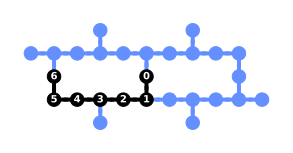

In [77]:
plot_circuit_layout(transpile(ansatze[0],backend_kol,optimization_level=3,
            initial_layout=Layout({ansatze[0].qubits[0]:13,
              ansatze[0].qubits[1]:14,
               ansatze[0].qubits[2]:11,
               ansatze[0].qubits[3]:8,
               ansatze[0].qubits[4]:5,
               ansatze[0].qubits[5]:3,
               ansatze[0].qubits[6]:2,                                                            
                }
        )
                   ),backend_kol)

In [108]:
from qiskit_nature.runtime.vqe_client import VQERuntimeResult

jobs=read('O2_job_ids_montreal')
results=[]
mont_energies=[]
for i in range(len(jobs)):
    results.append(make_result(service.job(jobs[i])))
    mont_energies.append(problems[i].interpret(results[i]).total_energies)
results_dict={'mont_energies':mont_energies,
              'mont_dists':[0.5,1.0,1.5,2.0,3.0]
             }
write_dict(results_dict,'O2 Calculated energies/mont_results')

Done writing dict into a binary file


In [ ]:
jobs=read('O2_job_ids_kolkata')
results=[]
kolk_energies=[]
for i in range(len(jobs)):
    results.apppend(make_result(jobs[i]))
    kolk_energies.append(problem.interpret(results[i]).total_energies)

    

Save results to file

In [ ]:
results_dict={'KS_energies':KS_energies,
              'rt_energies':rt_energies,
              'rt_dists':[0.5,1.0,1.5,2.0,3.0]
             }

In [ ]:
#write_dict(results_dict,'O2 Calculated energies/runtime_results')

### Final Results

Read results file

In [3]:
sim_results=read('O2 Calculated energies/O2_sim_results')
rt_results=read('O2 Calculated energies/runtime_results')

PYSCF Simulations

In [6]:
import pyscf
distances=np.arange(0.5,4,0.1)
FCI_energies=[]
for dist in distances:
    mol = pyscf.M(
        atom = 'O 0 0 0; O 0 0 '+str(dist),  # in Angstrom
        basis = 'sto-3g',
        symmetry = True,
        )
    myks = mol.RKS().run()

#
# create an FCI solver based on the SCF object
#
    cisolver = pyscf.fci.FCI(myks)
    FCI_energies.append(cisolver.kernel()[0])

converged SCF energy = -138.274197602407
converged SCF energy = -142.457625106419
converged SCF energy = -144.71175992414
converged SCF energy = -145.924602252722
converged SCF energy = -146.566710720835
converged SCF energy = -146.896235317028
converged SCF energy = -147.055512797871
converged SCF energy = -147.122107417202
converged SCF energy = -147.13760509073
converged SCF energy = -147.124421425373
converged SCF energy = -147.095365188387
converged SCF energy = -147.058472544069
converged SCF energy = -147.019051885971
converged SCF energy = -146.980473617392
converged SCF energy = -146.944618837162
converged SCF energy = -146.912318654737
converged SCF energy = -146.883779997022
converged SCF energy = -146.858908021422
SCF not converged.
SCF energy = -146.837236206588
SCF not converged.
SCF energy = -146.819119837695
SCF not converged.
SCF energy = -146.803975052783
SCF not converged.
SCF energy = -146.791545876451
SCF not converged.
SCF energy = -146.78152479123
SCF not converg

Filter and plot Data

In [7]:
RHF_copy=np.copy(sim_results['RHF_energies'])
RHF_copy=np.delete(RHF_copy,[34,7,4,3,2,1])
RKS_VQE_copy=np.copy(sim_results['RKS_VQE_EMB_energies'])
RKS_VQE_copy=np.delete(RKS_VQE_copy,[34,4,3,2,1])
RKS_VQE_copy2=np.copy(sim_results['RKS_VQE_energies'])
RKS_VQE_copy2=np.delete(RKS_VQE_copy2,[7])
FCI_copy=np.copy(FCI_energies)
FCI_copy=np.delete(FCI_copy,[34,4,3,2,1])

delta_classic=np.array([])
delta_vqe=np.array([])
delta_vqecl=np.array([])
for i in range(len(RHF_copy)):
    delta_classic=np.append(delta_classic,np.subtract(RHF_copy,sim_results['RKS_energies'])[i][i]/sim_results['RKS_energies'][i][0])
    delta_vqecl=np.append(delta_vqecl,np.subtract(RKS_VQE_copy2,sim_results['RKS_energies'])[i][i]/sim_results['RKS_energies'][i][0])
for i in range(len(RKS_VQE_copy)): 
    delta_vqefci=np.append(delta_vqecl,np.subtract(FCI_energies,sim_results['RKS_VQE_energies'])[i][i]/sim_results['RKS_VQE_energies'][i][0])
    delta_vqe=np.append(delta_vqe,np.subtract(RKS_VQE_copy,sim_results['RKS_VQE_energies'])[i][i]/sim_results['RKS_VQE_energies'][i][0])

/u/magbarroca/.conda/envs/qiskit-env/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


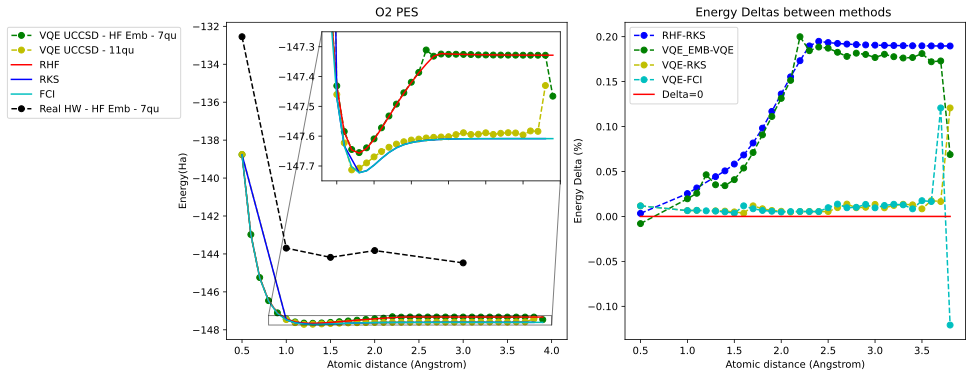

In [8]:
fig, ax=plt.subplots(1,2,figsize=(11,5))
fig.tight_layout()

ax[0].plot(sim_results['EMB_distances'], sim_results['RKS_VQE_EMB_energies'], '--go',label="VQE UCCSD - HF Emb - 7qu")
ax[0].plot(sim_results['RKS_VQE_distances'], sim_results['RKS_VQE_energies'], '--yo',label="VQE UCCSD - 11qu")
ax[0].plot(sim_results['EMB_distances'], sim_results['RHF_energies'], '-r',label="RHF")
ax[0].plot(sim_results['RKS_distances'], sim_results['RKS_energies'], '-b',label="RKS")
ax[0].plot(sim_results['EMB_distances'], FCI_energies, '-c',label="FCI")
ax[0].plot(rt_results['rt_dists'], rt_results['rt_energies'], '--ko',label="Real HW - HF Emb - 7qu")

axins = ax[0].inset_axes([0.28, 0.5, 0.7, 0.47])
axins.plot(sim_results['EMB_distances'], sim_results['RKS_VQE_EMB_energies'], '--go',label="VQE UCCSD - HF Emb - 7qu")
axins.plot(sim_results['RKS_VQE_distances'], sim_results['RKS_VQE_energies'], '--yo',label="VQE UCCSD - 11qu")
axins.plot(sim_results['EMB_distances'], sim_results['RHF_energies'], '-r',label="RHF")
axins.plot(sim_results['RKS_distances'], sim_results['RKS_energies'], '-b',label="RKS")
axins.plot(sim_results['EMB_distances'], FCI_energies, '-c',label="FCI")
axins.plot(rt_results['rt_dists'], rt_results['rt_energies'], '--ko',label="Real HW - HF Emb - 7qu")

x1, x2, y1, y2 = 0.8,4.0, -147.75, -147.25
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels([])
#axins.set_yticklabels([])

ax[0].indicate_inset_zoom(axins, edgecolor="black")

ax[0].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='O2 PES')
#ax[0].set_xlim([0.7,4])
#ax.set_ylim([-148,-147])
ax[0].legend(bbox_to_anchor=(-.12,1))

ax[1].plot(sim_results['RKS_distances'], -delta_classic*10**2, '--bo',label="RHF-RKS")
ax[1].plot(sim_results['RKS_VQE_distances'], -delta_vqe*10**2, '--go',label="VQE_EMB-VQE")
ax[1].plot(sim_results['RKS_distances'], -delta_vqecl*10**2, '--yo',label="VQE-RKS")
ax[1].plot(sim_results['RKS_VQE_distances'], -delta_vqefci*10**2, '--co',label="VQE-FCI")
ax[1].plot(sim_results['RKS_distances'], [0]*len(sim_results['RKS_distances']), '-r',label="Delta=0")
#ax[1].plot(sim_results['RKS_distances'], np.subtract(RHF_copy,sim_results['RKS_energies'][0])*10**3, '--bo',label="RHF-RKS")
#ax[1].plot(distances, exact_dipole,'r' ,label="Exact Energy")
ax[1].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy Delta (%)',title="Energy Deltas between methods ")
ax[1].legend()

plt.subplots_adjust(wspace=0.17)
plt.savefig('O2_PES',format='png',dpi=200)



<h2>LiF</h2>

In [102]:
#Define Molecule
molecule = MoleculeInfo(
             # coordinates in Angstrom
                     symbols=['Li','F'],
                     coords=[
                            (0.0 ,0.0 ,0.0),
                            (0.0 ,0.0 ,1.672)
                            ],
                     multiplicity=1,  # = 2*spin + 1
                     charge=0,
                     units=DistanceUnit.ANGSTROM
                    )
    
#Set driver
driver = PySCFDriver.from_molecule(molecule, basis="sto3g", method=MethodType.RKS)

#Get properties
og_problem = driver.run()
    
#particle_number = problem.grouped_property_transformed.get_property("ParticleNumber")
#num_a_electrons = problem.num_alpha
#num_b_electrons = propblem.num_beta
og_num_particles=og_problem.num_particles

og_num_spatial_orbitals =og_problem.num_spatial_orbitals

og_rep_energy = og_problem.nuclear_repulsion_energy
    
# Check the occupation of the spin orbitals
og_PN_property = og_problem.properties.particle_number

# Define the active space
# (selected automatically around the HOMO and LUMO, ordered by energy)
transformer = ActiveSpaceTransformer(
    num_electrons=(6,6), #Electrons in active space
    num_spatial_orbitals=10 #Orbitals in active space
    #,active_orbitals=np.arange(1,11,1)
)
    
#Define the problem

problem=transformer.transform(og_problem)

hamiltonian=problem.hamiltonian
second_q_op = hamiltonian.second_q_op() 
    
num_spatial_orbitals = problem.num_spatial_orbitals
num_particles = problem.num_particles
    
mapper=ParityMapper()

#Get Pauli OP
#converter = QubitConverter(mapper)
#qubit_op = converter.convert(hamiltonian)
    
#Symmetries
#sym=Z2Symmetries.find_Z2_symmetries(qubit_op)

converter = QubitConverter(mapper)
    
#Final OP
qubit_op = converter.convert(second_q_op,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)

In [103]:
og_num_spatial_orbitals

10

In [21]:
qubit_op.num_qubits

20

In [104]:
transformer = ActiveSpaceTransformer(
    num_electrons=(4,4), #Electrons in active space
    num_spatial_orbitals=5 #Orbitals in active space
    #,active_orbitals=np.arange(1,9,1)
)

problem = transformer.transform(og_problem)

num_spatial_orbitals = problem.num_spatial_orbitals
num_particles = problem.num_particles

hamiltonian=problem.hamiltonian
second_q_op = hamiltonian.second_q_op()
mapper=ParityMapper()
converter = QubitConverter(mapper
                                ,two_qubit_reduction=True
                                ,z2symmetry_reduction='auto'
                                #,z2symmetry_reduction=problem.symmetry_sector_locator(sym,converter)
                              )
qubit_op = converter.convert(second_q_op,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)

qubit_op.num_qubits

6

### Simulating

In [130]:
#Functions

def make_driver(dist):
    
    
    molecule = MoleculeInfo(
             # coordinates in Angstrom
                     symbols=['Li','F'],
                     coords=[
                            (0.0 ,0.0 ,0.0),
                            (0.0 ,0.0 ,1.672)
                            ],
                     multiplicity=1,  # = 2*spin + 1
                     charge=0,
                     units=DistanceUnit.ANGSTROM
                    )
    
    #Set driver
    driver = PySCFDriver.from_molecule(molecule, basis="sto3g", method=MethodType.RKS)

    #Get properties
    problem = driver.run()
    

    return driver, problem


def old_callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std['variance']))
    #clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std['variance'])

def make_qubit_op(og_problem, mapper, simplifications):
    
    if simplifications["HF_emb"]==True and simplifications["freeze_core"]==False:
        
        transformer = ActiveSpaceTransformer(
            num_electrons=(4,4), #Electrons in active space
            num_spatial_orbitals=5, #Orbitals in active space
        )

        problem = transformer.transform(og_problem)
         
    elif simplifications["HF_emb"]==False and simplifications["freeze_core"]==True:
        transformer=FreezeCoreTransformer(freeze_core=True)
        
        problem = transformer.transform(og_problem)
    
    else:
        problem = og_problem
        
    hamiltonian=problem.hamiltonian
    second_q_op = hamiltonian.second_q_op() # Get 2nd Quant OP. This calls driver.run() internally
    
    num_spatial_orbitals = problem.num_spatial_orbitals
    num_particles = problem.num_particles
    

    #Get Pauli OP
    if simplifications["z2symmetry_reduction"]==True and simplifications["two_qubit_reduction"]==True:
        converter = QubitConverter(mapper,two_qubit_reduction=True, z2symmetry_reduction='auto')
                              
    elif simplifications["z2symmetry_reduction"]==False and simplifications["two_qubit_reduction"]==True:
        converter = QubitConverter(mapper,two_qubit_reduction=True)
        
    elif simplifications["z2symmetry_reduction"]==True and simplifications["two_qubit_reduction"]==False:
        converter = QubitConverter(mapper,z2symmetry_reduction='auto')
                                   
    else:
        converter = QubitConverter(mapper)
        
        
    
    #Final OP
    qubit_op = converter.convert(second_q_op,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)
    
    
    return qubit_op, num_particles, num_spatial_orbitals, converter, problem
                                   
def exact_solver(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

def local_solver(distances,mapper,optimizer,simp):
    
    dists=[]
    results=[]
    for dist in distances:
        #Driver
        driver,og_problem=make_driver(dist)
        #Qubit_Op
        qubit_op, num_particles, num_spatial_orbitals, converter, problem = make_qubit_op(og_problem,mapper,simp)
        #Initial State
        init_state = HartreeFock(num_spatial_orbitals, num_particles, converter)
        #ansatz = UCCSD(num_spatial_orbitals,num_particles,converter)
        ansatz = EfficientSU2(num_qubits=qubit_op.num_qubits,su2_gates='ry', entanglement='linear', reps=3, initial_state=init_state)
        # Set initial parameters of the ansatz
        initial_point = np.pi/4 * np.random.rand(ansatz.num_parameters)
        
        estimator = Estimator([ansatz], [qubit_op])
    
        counts = []
        values = []
        deviation = []
    
        custom_vqe = CustomVQE(estimator, ansatz, optimizer, callback=callback)

        result = custom_vqe.compute_minimum_eigenvalue(qubit_op,initial_point=initial_point)
        
        results.append(result)
        dists.append(dist)
    
    return results, distances

def sim_solver(distances, mapper, optimizer,est_options, simp,noise,device):
    
    dists=[]
    results=[]
                             
    for dist in distances:
        #Driver
        driver,og_problem=make_driver(dist)
        #Qubit_Op
        qubit_op, num_particles, num_spatial_orbitals, converter, problem = make_qubit_op(og_problem,mapper,simp)
        #Initial State
        init_state = HartreeFock(num_spatial_orbitals, num_particles, converter)
        #ansatz = UCCSD(num_spatial_orbitals,num_particles,converter)
        ansatz = EfficientSU2(num_qubits=qubit_op.num_qubits,su2_gates='ry', entanglement='linear', reps=3, initial_state=init_state)
        if noise==False:
            ansatz_opt = transpile(ansatz, backend=provider.get_backend(device),optimization_level=3,routing_method='sabre')
            small_qc = mm.deflate_circuit(ansatz_opt)
            layouts = mm.matching_layouts(small_qc, provider.get_backend(device))
            scores = mm.evaluate_layouts(small_qc, layouts, provider.get_backend(device))
            ansatz = transpile(small_qc, backend=provider.get_backend(device),initial_layout=scores[0][0],optimization_level=3,routing_method='sabre')
        # Set initial parameters of the ansatz
        initial_point = np.pi/4 * np.random.rand(ansatz.num_parameters)
    
        count_sim = []
        values_sim = []
        deviation_sim = []
    
        with Session(service=service, backend='ibmq_qasm_simulator') as session:
            # Prepare primitive
            rt_estimator = RuntimeEstimator(session=session,options=est_options)
            # Set up algorithm
            custom_vqe = CustomVQE(rt_estimator, ansatz, optimizer, callback=callback_sim)
            # Run algorithm
            vresult= custom_vqe.compute_minimum_eigenvalue(qubit_op,initial_point)

        results.append(result)      
            
        dists.append(dist)
       
        
    return results, distances

def real_solver(distances, mapper, optimizer,est_options, device,simp):
    
    dists=[]
    results=[]
                             
    for dist in distances:
        #Driver
        driver,og_problem=make_driver(dist)
        #Qubit_Op
        qubit_op, num_particles, num_spatial_orbitals, converter, problem = make_qubit_op(og_problem,mapper,simp)
        #Initial State
        init_state = HartreeFock(num_spatial_orbitals, num_particles, converter)
        #ansatz = UCCSD(num_spatial_orbitals,num_particles,converter)
        ansatz = EfficientSU2(num_qubits=qubit_op.num_qubits,su2_gates='ry', entanglement='linear', reps=3, initial_state=init_state)
        #ansatz_opt = transpile(ansatz, backend=provider.get_backend(device),optimization_level=3,routing_method='sabre')
        #small_qc = mm.deflate_circuit(ansatz_opt)
        #layouts = mm.matching_layouts(small_qc, provider.get_backend(device))
        #scores = mm.evaluate_layouts(small_qc, layouts, provider.get_backend(device))
        #ansatz = transpile(small_qc, backend=provider.get_backend(device),initial_layout=scores[0][0],optimization_level=3,routing_method='sabre')
        
        # Set initial parameters of the ansatz
        initial_point = np.pi/4 * np.random.rand(ansatz.num_parameters)
    
        counts_real = []
        values_real = []
        deviation_real = []
    
        with Session(service=service, backend=device) as session:
            # Prepare primitive
            rt_estimator = RuntimeEstimator(session=session,options=est_options)
            # Set up algorithm
            custom_vqe = CustomVQE(rt_estimator, ansatz, optimizer, callback=callback_sim)
            # Run algorithm
            result = custom_vqe.compute_minimum_eigenvalue(qubit_op,initial_point)

        results.append(result)
        
            
        dists.append(dist)
       
        
    return results, distances

def classic_solver(distances,mapper,optimizer,simp):
    
    results=[]
    dists=[]
    for dist in distances:
        #Driver
        driver,og_problem=make_driver(dist)
        #Qubit_Op
        qubit_op, num_particles, num_spatial_orbitals, converter, problem = make_qubit_op(og_problem,mapper,simp)
        result= exact_solver(problem, converter = converter)
        results.append(result)
        dists.append(dist)
    return results,dists

In [56]:
from qiskit.providers.fake_provider import FakeManila, FakeNairobi, FakeMontreal

#Noisy simulator
backend_aer = AerSimulator(method='density_matrix',device='CPU')
device_backend=FakeMontreal()
device = AerSimulator.from_backend(device_backend)
noise_model = None
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

In [68]:
#Runtime Estimator options
ts_opt=TranspilationOptions(
    skip_transpilation=True
)

sim_opt=SimulatorOptions(
    noise_model=noise_model,
    seed_simulator=62,
    coupling_map=coupling_map,
    basis_gates=basis_gates
)
res_opt=ResilienceOptions(
    noise_factors=tuple(range(1, 6, 2)),
    noise_amplifier='LocalFoldingAmplifier',
    extrapolator='LinearExtrapolator'
)
est_options=Options(
    resilience_level=1,
    #optimization_level=3,
    resilience=res_opt,
    simulator=sim_opt,
    #transpilation=ts_opt
)

In [54]:
simp={"z2symmetry_reduction":True,
                 "two_qubit_reduction":True,
                 "freeze_core":False,
                 "HF_emb":True
}

distances = np.arange(0.5, 0.7, 0.1)
optimizer = SLSQP(maxiter=3)
mapper=ParityMapper()


seed = 62
algorithm_globals.random_seed = seed
#qi=backend_aer
#qi= QuantumInstance(backend_aer, seed_simulator=seed, seed_transpiler=seed, #Noisy Quantum Instance
#                          coupling_map=coupling_map,noise_model=noise_model,
#                          measurement_error_mitigation_cls=CompleteMeasFitter)

In [131]:

counts = []
values = []
deviation = []

results,dists=local_solver(                                                             distances=distances,
                                                                          mapper=mapper,
                                                                          optimizer=optimizer,
                                                                          simp=simp)

'Evaluation: 77, Energy: -21.815638101084794, Std: {}'

In [132]:
print(problem.interpret(results[0]))

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -109.66815397143
  - computed part:      -21.555262298745
  - ActiveSpaceTransformer extracted energy part: -88.112891672685
~ Nuclear repulsion energy (Hartree): 8.545325774426
> Total ground state energy (Hartree): -101.122828197004
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  28.43659872]
 


In [118]:
results[0]

In [105]:
print(problem.interpret(eigen_results[0]))

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -109.829077105177
  - computed part:      -21.716185432493
  - ActiveSpaceTransformer extracted energy part: -88.112891672685
~ Nuclear repulsion energy (Hartree): 8.545325774426
> Total ground state energy (Hartree): -101.283751330752
 
=== MEASURED OBSERVABLES ===
 
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  28.43659872]
 


In [113]:
counts_sim = []
values_sim = []
deviation_sim = []

vqe_results,eigen_results,ress,dists= real_solver(distances=distances, mapper=mapper, optimizer=optimizer,est_options=est_options, simp=simp,device='ibmq_montreal')

KeyboardInterrupt: 

In [53]:
print(results[0])

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 256,
    'eigenstate': None,
    'eigenvalue': -25.199082511785296,
    'optimal_circuit': None,
    'optimal_parameters': array([-0.10764643,  0.15950699,  0.11741894,  0.03226411, -0.38936298,
        1.91041494,  1.871471  , -0.0726977 ,  1.29962782,  0.08475955,
        0.13384055,  0.19022059,  2.14507222, -0.40972546,  1.37401814,
        1.46886437,  1.59727104,  1.21250974,  1.13728998, -0.00863611,
        1.52451403,  0.95718829,  0.09942657,  0.41121319]),
    'optimal_point': None,
    'optimal_value': None,
    'optimizer_evals': None,
    'optimizer_result': None,
    'optimizer_time': None}


In [71]:
results,dists=classic_solver(distances=distances,mapper=mapper,optimizer=optimizer,simp=simp)

In [73]:
print(results[0])

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -113.876414227127
  - computed part:      -25.763522554442
  - ActiveSpaceTransformer extracted energy part: -88.112891672685
~ Nuclear repulsion energy (Hartree): 8.545325774426
> Total ground state energy (Hartree): -105.331088452701
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 8.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  28.43659872]
 
  0: 
  * Electronic dipole moment (a.u.): [None  None  29.43071852]
    - computed part:      [None  None  23.10619659]
    - ActiveSpaceTransformer extracted energy part: [0.0  0.0  6.32452193]
  > Dipole moment (a.u.): [None  None  -0.9941198]  Total: None
                 (debye): [None  None  -2.52680026]  Total: None
 


In [28]:
results_dict={'RKS_VQE_energies':RKS_vqe_energies,
             'RKS_energies': RKS_energies,
             'RKS_dists':distances,
}

write_dict(results_dict, 'LiF Calculated energies/LiF_sim_results')

Done writing dict into a binary file


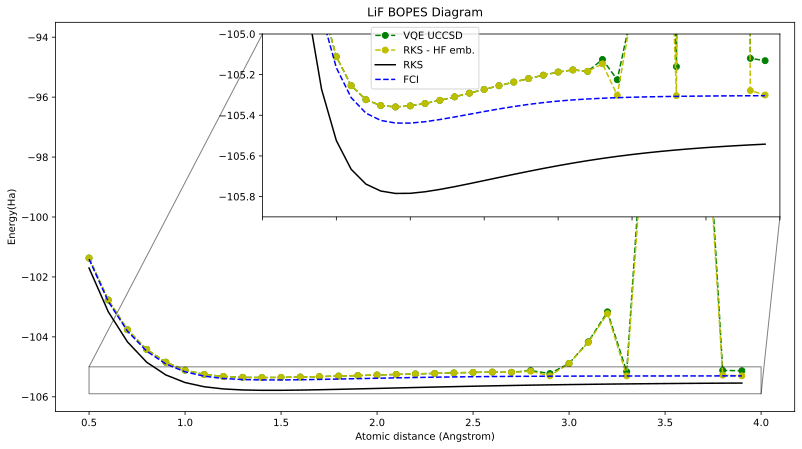

In [91]:
fig, ax=plt.subplots(1,1,figsize=(11,6))
fig.tight_layout()


ax.plot(RKS_dists, RKS_vqe_energies, '--go',label="VQE UCCSD")
ax.plot(RKS_dists, RKS_energies, '--yo',label="RKS - HF emb.")
ax.plot(RKS_dists, KS_energies, '-k',label="RKS")
ax.plot(RKS_dists, FCI_energies, '--b',label="FCI")
ax.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='LiF BOPES Diagram')
#ax[0].set_xlim([0.7,4])
#ax[0].set_ylim([-148,-147])
ax.legend()

axins = ax.inset_axes([0.28, 0.5, 0.7, 0.47])
axins.plot(RKS_dists, RKS_vqe_energies, '--go',label="VQE UCCSD")
axins.plot(RKS_dists, RKS_energies, '--yo',label="RKS - HF emb.")
axins.plot(RKS_dists, KS_energies, '-k',label="RKS")
axins.plot(RKS_dists, FCI_energies, '--b',label="FCI")

x1, x2, y1, y2 = 0.5,4.0, -105.9, -105
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels([])
#axins.set_yticklabels([])

ax.indicate_inset_zoom(axins, edgecolor="black")

#ax[1].plot(sim_results['RKS_distances'], -delta_classic*10**2, '--bo',label="RHF-RKS")
#ax[1].plot(sim_results['RKS_VQE_distances'], -delta_vqe*10**2, '--go',label="VQE_EMB-VQE")
#ax[1].plot(sim_results['RKS_distances'], -delta_vqecl*10**2, '--yo',label="VQE-RKS")
#ax[1].plot(sim_results['RKS_VQE_distances'], -delta_vqefci*10**2, '--co',label="VQE-FCI")
#ax[1].plot(sim_results['RKS_distances'], [0]*len(sim_results['RKS_distances']), '-r',label="Delta=0")
#ax[1].plot(sim_results['RKS_distances'], np.subtract(RHF_copy,sim_results['RKS_energies'][0])*10**3, '--bo',label="RHF-RKS")
#ax[1].plot(distances, exact_dipole,'r' ,label="Exact Energy")
#ax[1].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy Delta (%)',title="Energy Deltas between methods ")
#ax[1].legend()

plt.subplots_adjust(wspace=0.17)
plt.show()

### Real HW

In [121]:
from qiskit_nature.runtime.vqe_client import VQERuntimeResult

def rt_callback(nfev, parameters, energy, stddev):
    display("Energy: {}, Std: {}".format(energy, stddev))
    clear_output(wait=True)
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)
    
def raw_callback(*args):
    # check if interim results, since both interim results (list) and final results (dict) are returned
    if type(args[1]) is list:
        job_id, (nfev, parameters, energy, stddev) = args
        display("Job_id: {} Energy: {}, Std: {}".format(job_id,energy, stddev))
        clear_output(wait=True)
        intermediate_info["nfev"].append(nfev)
        intermediate_info["parameters"].append(parameters)
        intermediate_info["energy"].append(energy)
        intermediate_info["stddev"].append(stddev)

def hw_solver(distances, mapper, optimizer, simp,backend):
    
    measurement_error_mitigation = True
    store_intermediate=True
        
    classic_energies = []
    rt_energies = []
    dists=[]
    
    intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
    }
                             
    for dist in distances:
        #Driver
        driver,og_problem=make_driver(dist)
        #Qubit_Op
        qubit_op, num_particles, num_spatial_orbitals, converter, problem = make_qubit_op(og_problem,mapper,simp)
        #Initial State
        init_state = HartreeFock(num_spatial_orbitals, num_particles, converter)
      #  try:
        #ansatz
        ansatz = EfficientSU2(num_qubits=qubit_op.num_qubits,su2_gates='ry', entanglement='linear', reps=3, initial_state=init_state)
    
        #VQE    
        # Set initial parameters of the ansatz
        initial_point = [0.01] * ansatz.num_parameters
            
        runtime_vqe = VQEClient(ansatz=ansatz,
                         optimizer=optimizer,
                         initial_point=initial_point,
                         provider=provider,
                         backend=backend,
                         shots=sh,
                         measurement_error_mitigation=measurement_error_mitigation,
                         callback=rt_callback,
                         store_intermediate=store_intermediate)

        rt_result = runtime_vqe.compute_minimum_eigenvalue(qubit_op)
        #rt_energies.append(problem.interpret(rt_result).total_energies)
    
        #Classic Solver
        result_exact = exact_solver(problem, converter = converter)
        classic_energies.append(result_exact.total_energies)
      #  except:
        #    pass
        
    return rt_result,classic_energies, rt_energies, dists 

def make_result(job):
    vqe_result = VQERuntimeResult()
    result=job.result()
    vqe_result.job_id = job.job_id
    vqe_result.cost_function_evals = result.get("cost_function_evals", None)
    vqe_result.eigenstate = result.get("eigenstate", None)
    vqe_result.eigenvalue = result.get("eigenvalue", None)
    aux_op_eigenvalues = result.get("aux_operator_eigenvalues", None)
    vqe_result.aux_operator_eigenvalues = aux_op_eigenvalues
    vqe_result.optimal_parameters = result.get("optimal_parameters", None)
    vqe_result.optimal_point = result.get("optimal_point", None)
    vqe_result.optimal_value = result.get("optimal_value", None)
    vqe_result.optimizer_evals = result.get("optimizer_evals", None)
    vqe_result.optimizer_time = result.get("optimizer_time", None)
    vqe_result.optimizer_history = result.get("optimizer_history", None)
    
    return vqe_result



In [117]:
IBMQ.load_account()
provider = IBMQ.get_provider(group='deployed')
backend_kol=provider.get_backend('ibmq_kolkata')
backend_mont=provider.get_backend('ibmq_montreal')
backend_qasm=provider.get_backend('ibmq_qasm_simulator')


ibmqfactory.load_account:WARNING:2022-11-09 17:31:57,256: Credentials are already in use. The existing account in the session will be replaced.


Set parameters and run

In [122]:
#VQE CLIENT

from qiskit_nature.runtime import VQEClient
simp={"z2symmetry_reduction":True,
                 "two_qubit_reduction":True,
                 "freeze_core":False,
                 "HF_emb":True
}

distances = [0.5,1.0,1.5,2.0,2.5,3.0]
optimizer = SPSA(maxiter=50)
mapper=ParityMapper()


rt_result, KS_energies, rt_energies, rt_dists = hw_solver(distances,mapper,optimizer,simp,backend_qasm)
KS_energies

KeyboardInterrupt: 

In [123]:
rt_result

NameError: name 'rt_result' is not defined

Running on Montreal

In [111]:
from qiskit_ibm_runtime import QiskitRuntimeService

simp={"z2symmetry_reduction":True,
                 "two_qubit_reduction":True,
                 "freeze_core":False,
                 "HF_emb":True
}

service = QiskitRuntimeService()
options = {"backend_name" : "ibmq_kolkata"}
distances = np.arange(0.5,3,.25)
optimizer = SPSA(maxiter=100)
mapper=ParityMapper()
qubit_ops=[]
problems=[]
ansatze=[]

job_ids=[]

In [112]:
#VQE RUNTIME


for dist in distances:
    
    driver,og_problem=make_driver(dist)
    #Qubit_Op
    qubit_op, num_particles, num_spatial_orbitals, converter, problem = make_qubit_op(og_problem,mapper,simp)
    problems.append(problem)
    qubit_ops.append(qubit_op)
    #X_D=converter.convert(second_q_ops[4],num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)
    #Y_D=converter.convert(second_q_ops[5],num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)
    #Z_D=converter.convert(second_q_ops[6],num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)
    #Initial State
    init_state = HartreeFock(num_spatial_orbitals, num_particles, converter)
    #ansatz
    ansatze.append(EfficientSU2(num_qubits=qubit_op.num_qubits,su2_gates='ry', entanglement='linear', reps=3, initial_state=init_state))


In [113]:
qubit_ops[4].num_qubits

6

In [115]:
from qiskit.transpiler import Layout
job_ids=[]
options = {"backend_name" : "ibmq_montreal"}  
for i,qubit_op in enumerate(qubit_ops):
    initial_point = np.random.uniform(-np.pi, np.pi, len(ansatze[i].parameters))
    #initial_layout=[22,19,16,14,11,8,5,3,2,1,4,7]#{0:13,1:14,2:11,3:8,4:5,5:3,6:2,}           
    vqe_inputs = {
        "ansatz": ansatze[i],
        "operator": qubit_op,
        "optimizer": optimizer,  
        "initial_parameters": initial_point,
        #"initial_layout": initial_layout,
        "measurement_error_mitigation": True,
        "shots": 5096,
    }

    intermediate_info = {"nfev": [], "parameters": [], "energy": [], "stddev": []}
    
    job= service.run(
    program_id="vqe", inputs=vqe_inputs, options=options, callback=raw_callback)
    job_ids.append(job.job_id())

#write_list(job_ids,'LiF Calculated energies/LiF_job_ids_mem')
#write_list(job_ids,'LiF Calculated energies/LiF_job_ids')

['cdm0noian60ka16k7h9g',
 'cdm0np5f14jb6brmb8b0',
 'cdm0np7tlcfkm5f6cfqg',
 'cdm0npa2h6kvivdh3de0',
 'cdm0nplf14jb6brmb8dg',
 'cdm0nppg1234sbn3tjog',
 'cdm0npq2h6kvivdh3dh0',
 'cdm0nq6h8o8scshedld0',
 'cdm0nq9g1234sbn3tjt0',
 'cdm0nqi2h6kvivdh3dlg']

In [4]:
#jobs=read('LiF Calculated energies/LiF_job_ids')
jobs=read('LiF Calculated energies/LiF_job_ids_mem')

distances = np.arange(0.6,2.75,.25)
results=[]
kolk_energies=[]
for i in range(1,len(jobs)-1):
    results.append(make_result(service.job(jobs[i])))
    kolk_energies.append(problems[i].interpret(results[i-1]).total_energies)

NameError: name 'make_result' is not defined

In [3]:
jobs=read('LiF Calculated energies/LiF_job_ids')

In [4]:
jobs

['cc7rgjcbe35rsshpqo10',
 'cc7rgjin6sj4pjban3j0',
 'cc7rgjrfk1pntg9jqtlg',
 'cc7rgk2vb7prqi8mt570',
 'cc7rgkflnghj2nv08o40',
 'cc7rgkngkoe40ibr7e70',
 'cc7rgkkbe35rsshpqo5g',
 'cc7rgkvlnghj2nv08o60',
 'cc7rgl3fk1pntg9jqtr0',
 'cc7rgl2vb7prqi8mt5b0']

In [17]:
kolk_energies

[array([-102.82640424+0.j]),
 array([-102.81577593+0.j]),
 array([-102.56244628+0.j]),
 array([-104.14895467+0.j]),
 array([-103.15913383+0.j]),
 array([-103.2624483+0.j]),
 array([-98.16638089+0.j]),
 array([-104.05338631+0.j])]

In [23]:
distances = np.arange(0.5,2.75,.25)
results_dict={'rt_energies':kolk_energies,
              'rt_dists':distances[1::]
             }
write_dict(results_dict, 'LiF Calculated energies/LiF_kolk_results_mem')
#write_dict(results_dict, 'LiF Calculated energies/LiF_kolk_results')

Done writing dict into a binary file


In [24]:
results_dict['rt_dists']

array([0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ])

### PYSCF

In [16]:
import pyscf
from pyscf import gto, scf, cc, fci, dft
distances=np.arange(0.5,4,0.1)
FCI_energies=[]
KS_energies=[]
for dist in distances:
    mol = pyscf.M(
        atom = 'Li 0 0 0; F 0 0 '+str(dist),  # in Angstrom
        basis = 'sto-3g',
        symmetry = True,
        )
    myks = mol.RKS().run()
    mf_ks = dft.RKS(mol)
    mf_ks.xc = 'b3lyp' # default
    mf_ks = mf_ks.newton() # second-order algortihm
    #myccisd = mf.CISD().run()
    #print('UCISD correlation energy', myccisd.e_corr)
    #cisolver = fci.FCI(mol, mf.mo_coeff)
    #print('E(FCI) = %.12f' % cisolver.kernel()[0])
    KS_energies.append(mf_ks.kernel())

#
# create an FCI solver based on the SCF object
#
    cisolver = pyscf.fci.FCI(myks)
    FCI_energies.append(cisolver.kernel()[0])

converged SCF energy = -101.000915458502
converged SCF energy = -101.702960943584
converged SCF energy = -102.467439622389
converged SCF energy = -103.160824455189
converged SCF energy = -103.472645836824
converged SCF energy = -104.166880530569
converged SCF energy = -104.139450385141
converged SCF energy = -104.846431910899
converged SCF energy = -104.551909632604
converged SCF energy = -105.271980374746
converged SCF energy = -104.794918869019
converged SCF energy = -105.524715556088
converged SCF energy = -104.929501181922
converged SCF energy = -105.665543749151
converged SCF energy = -104.999231631515
converged SCF energy = -105.73866972279
converged SCF energy = -105.031903900794
converged SCF energy = -105.772714581404
converged SCF energy = -105.043590139445
converged SCF energy = -105.78460874651
converged SCF energy = -105.043315728184
converged SCF energy = -105.784018225768
converged SCF energy = -105.036220875803
converged SCF energy = -105.776391942589
converged SCF ener

### Results

In [14]:
rt_results_mem=read('LiF Calculated energies/LiF_kolk_results_mem')
rt_results=read('LiF Calculated energies/LiF_kolk_results')
sim_results=read('LiF Calculated energies/LiF_sim_results')

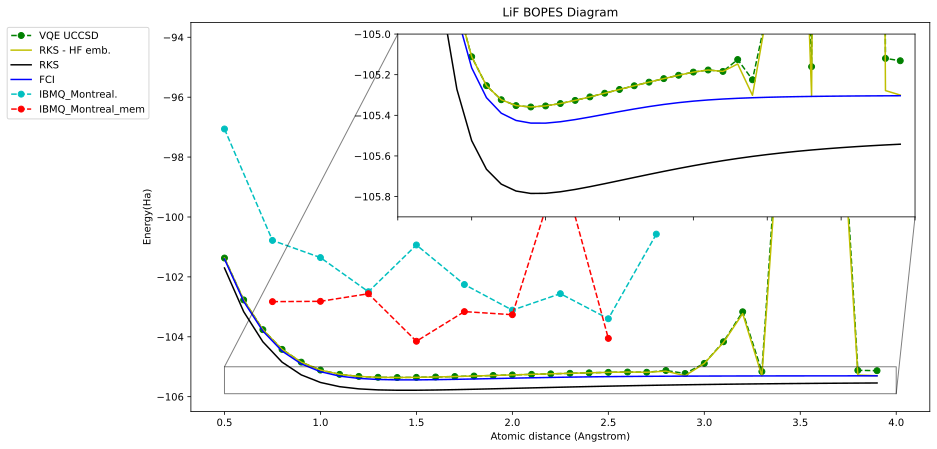

In [17]:
distances=np.arange(0.5,4,0.1)

fig, ax=plt.subplots(1,1,figsize=(11,6))
fig.tight_layout()


ax.plot(sim_results['RKS_dists'], sim_results['RKS_VQE_energies'], '--go',label="VQE UCCSD")
ax.plot(sim_results['RKS_dists'], sim_results['RKS_energies'], '-y',label="RKS - HF emb.")
ax.plot(distances, KS_energies, '-k',label="RKS")
ax.plot(distances, FCI_energies, '-b',label="FCI")
ax.plot(rt_results['rt_dists'], rt_results['rt_energies'], '--co',label="IBMQ_Montreal.")
ax.plot(rt_results_mem['rt_dists'], rt_results_mem['rt_energies'], '--ro',label="IBMQ_Montreal_mem")
ax.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='LiF BOPES Diagram')
#ax[0].set_xlim([0.7,4])
#ax[0].set_ylim([-148,-147])
ax.legend(bbox_to_anchor=(-.05,1))


axins = ax.inset_axes([0.28, 0.5, 0.7, 0.47])
axins.plot(sim_results['RKS_dists'], sim_results['RKS_VQE_energies'], '--go',label="VQE UCCSD")
axins.plot(sim_results['RKS_dists'], sim_results['RKS_energies'], '-y',label="RKS - HF emb.")
axins.plot(distances, KS_energies, '-k',label="RKS")
axins.plot(distances, FCI_energies, '-b',label="FCI")

x1, x2, y1, y2 = 0.5,4.0, -105.9, -105
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels([])
#axins.set_yticklabels([])

ax.indicate_inset_zoom(axins, edgecolor="black")

#ax[1].plot(sim_results['RKS_distances'], -delta_classic*10**2, '--bo',label="RHF-RKS")
#ax[1].plot(sim_results['RKS_VQE_distances'], -delta_vqe*10**2, '--go',label="VQE_EMB-VQE")
#ax[1].plot(sim_results['RKS_distances'], -delta_vqecl*10**2, '--yo',label="VQE-RKS")
#ax[1].plot(sim_results['RKS_VQE_distances'], -delta_vqefci*10**2, '--co',label="VQE-FCI")
#ax[1].plot(sim_results['RKS_distances'], [0]*len(sim_results['RKS_distances']), '-r',label="Delta=0")
#ax[1].plot(sim_results['RKS_distances'], np.subtract(RHF_copy,sim_results['RKS_energies'][0])*10**3, '--bo',label="RHF-RKS")
#ax[1].plot(distances, exact_dipole,'r' ,label="Exact Energy")
#ax[1].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy Delta (%)',title="Energy Deltas between methods ")
#ax[1].legend()

plt.subplots_adjust(wspace=0.17)
plt.show()

In [21]:
sim_results['RKS_energies'][10]

array([-105.35373944+0.j])

In [22]:
rt_results_mem['rt_energies'][3]

array([-104.14895467+0.j])

In [25]:
FCI_energies[10]

-105.43845093034949

<h2>LiCl</h2>

In [3]:
#Define Molecule
molecule = Molecule(
             # coordinates in Angstrom
                    geometry=[
                            ["Li", [0.0 ,0.0 ,0.0]],
                        
                            ["Cl", [0.0 ,0.0 ,1.672]],
                            ],
                     multiplicity=1,  # = 2*spin + 1
                     charge=0
                    )
    
#Set driver
driver = ElectronicStructureMoleculeDriver(
    molecule=molecule,
    basis="sto3g",
    driver_type=ElectronicStructureDriverType.PYSCF,
    )

#Get properties
properties = driver.run()
    
#particle_number = problem.grouped_property_transformed.get_property("ParticleNumber")
num_a_electrons = properties.get_property("ParticleNumber").num_alpha
num_b_electrons = properties.get_property("ParticleNumber").num_beta
num_particles=properties.get_property("ParticleNumber").num_particles

num_spin_orbitals =int(properties.get_property("ParticleNumber").num_spin_orbitals)

rep_energy = properties.get_property("ElectronicEnergy").nuclear_repulsion_energy
    
# Check the occupation of the spin orbitals
PN_property = properties.get_property("ParticleNumber")

# Define the active space
# (selected automatically around the HOMO and LUMO, ordered by energy)
transformer = ActiveSpaceTransformer(
    num_electrons=(8,8), #Electrons in active space
    num_molecular_orbitals=9 #Orbitals in active space
    #,active_orbitals=np.arange(1,11,1)
)
    
#Define the problem

problem = ElectronicStructureProblem(driver)
    
second_q_ops = problem.second_q_ops() # Get 2nd Quant OP. This calls driver.run() internally
    
num_spin_orbitals = problem.num_spin_orbitals
num_particles = problem.num_particles
    
hamiltonian = second_q_ops[0] #Set Hamiltonian
mapper=ParityMapper()

#Get Pauli OP
#converter = QubitConverter(mapper)
#qubit_op = converter.convert(hamiltonian)
    
#Symmetries
#sym=Z2Symmetries.find_Z2_symmetries(qubit_op)

converter = QubitConverter(mapper)
    
#Final OP
qubit_op = converter.convert(hamiltonian,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)

/opt/homebrew/Caskroom/miniforge/base/envs/qiskit-env/lib/python3.9/site-packages/qiskit_nature/problems/second_quantization/electronic/electronic_structure_problem.py:93: ListAuxOpsDeprecationWarning: List-based `aux_operators` are deprecated as of version 0.3.0 and support for them will be removed no sooner than 3 months after the release. Instead, use dict-based `aux_operators`. You can switch to the dict-based interface immediately, by setting `qiskit_nature.settings.dict_aux_operators` to `True`.
  second_quantized_ops = self._grouped_property_transformed.second_q_ops()


In [17]:
print(properties)

ElectronicStructureDriverResult:
	DriverMetadata:
		Program: PYSCF
		Version: 2.0.1
		Config:
			atom=Li 0.0 0.0 0.0;Cl 0.0 0.0 1.672
			unit=Angstrom
			charge=0
			spin=0
			basis=sto3g
			method=rhf
			conv_tol=1e-09
			max_cycle=50
			init_guess=minao
			max_memory=4000
			
	ElectronicBasisTransform:
		Initial basis: atomic
		Final basis: molecular
		Alpha coefficients:
		[0, 0] = 4.6614976330336725e-05
		[0, 1] = -0.001292068487216077
		[0, 2] = 0.0030964532125521862
		[0, 3] = 3.396078620291626e-17
		[0, 4] = 1.0531877955161791e-16
		[0, 5] = 0.9870390409670746
		[0, 6] = -0.12191329225843024
		[0, 7] = 0.16601222180150088
		[0, 8] = -3.2084629387165323e-15
		[0, 9] = 9.650673448383867e-16
		[0, 10] = -0.22145732876952173
		[0, 11] = 6.235588670503266e-16
		[0, 12] = -1.785060005913874e-15
		[0, 13] = -0.05714973767054943
		[1, 0] = 0.0007522437497920521
		[1, 1] = -0.015205461377705603
		[1, 2] = 0.009988722475495518
		[1, 3] = 1.1678089147468049e-16
		[1, 4] = 3.298944791524884

In [ ]:
#qubit_op = converter.convert(hamiltonian,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)

In [18]:
qubit_op.num_qubits

28

In [6]:
transformer = ActiveSpaceTransformer(
    num_electrons=(4,4), #Electrons in active space
    num_molecular_orbitals=5 #Orbitals in active space
    #,active_orbitals=np.arange(1,9,1)
)

problem = ElectronicStructureProblem(driver, [transformer])

second_q_ops = problem.second_q_ops()
hamiltonian = second_q_ops[0]
mapper=ParityMapper()
converter = QubitConverter(mapper
                                ,two_qubit_reduction=True
                                ,z2symmetry_reduction='auto'
                                #,z2symmetry_reduction=problem.symmetry_sector_locator(sym,converter)
                              )
qubit_op = converter.convert(hamiltonian,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)
qubit_op.num_qubits

6

In [3]:
#Functions

def make_driver(dist):
    
    
    #Define Molecule
    molecule = Molecule(
        # coordinates in Angstrom
        geometry=[
            ["Li", [0.0, 0.0, 0.0]],
            ["Cl", [dist, 0.0, 0.0]]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )
    
    #Set driver
    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF,
        method=MethodType.RKS
        
    )

    #Get properties
    properties = driver.run()
    

    return driver, properties


def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

def make_qubit_op(driver,mapper, simplifications):

    if simplifications["HF_emb"]==True and simplifications["freeze_core"]==True:
        transformer = ActiveSpaceTransformer(
            num_electrons=(4,4), #Electrons in active space
            num_molecular_orbitals=4, #Orbitals in active space
        )

        problem = ElectronicStructureProblem(driver,[transformer,FreezeCoreTransformer(freeze_core=True)])
    
    elif simplifications["HF_emb"]==True and simplifications["freeze_core"]==False:
        
        transformer = ActiveSpaceTransformer(
            num_electrons=(4,4), #Electrons in active space
            num_molecular_orbitals=5, #Orbitals in active space
        )

        problem = ElectronicStructureProblem(driver,[transformer])
         
    elif simplifications["HF_emb"]==False and simplifications["freeze_core"]==True:
        problem = ElectronicStructureProblem(driver,[FreezeCoreTransformer(freeze_core=True)])
    
    else:
         problem = ElectronicStructureProblem(driver)
        
    
    second_q_ops = problem.second_q_ops() # Get 2nd Quant OP. This calls driver.run() internally
    
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles
    
    hamiltonian = second_q_ops[0] #Set Hamiltonian

    #Get Pauli OP
    if simplifications["z2symmetry_reduction"]==True and simplifications["two_qubit_reduction"]==True:
        converter = QubitConverter(mapper,two_qubit_reduction=True, z2symmetry_reduction='auto')
                              
    elif simplifications["z2symmetry_reduction"]==False and simplifications["two_qubit_reduction"]==True:
        converter = QubitConverter(mapper,two_qubit_reduction=True)
        
    elif simplifications["z2symmetry_reduction"]==True and simplifications["two_qubit_reduction"]==False:
        converter = QubitConverter(mapper,z2symmetry_reduction='auto')
                                   
    else:
        converter = QubitConverter(mapper)
        
        
    
    #Final OP
    qubit_op = converter.convert(hamiltonian,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)
    
    
    return qubit_op, num_particles, num_spin_orbitals, converter, problem
                                   
def exact_solver(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

def sim_solver(distances, mapper, optimizer, simp):
        
    classic_energies = []
    vqe_energies = []
    avqe_energies=[]
    dists=[]
                             
    for dist in distances:
        #Driver
        driver,propertiesr=make_driver(dist)
        #Qubit_Op
        qubit_op, num_particles, num_spin_orbitals, converter, problem = make_qubit_op(driver,mapper,simp)
        #Initial State
        init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
        ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
    
        #VQE
  

        counts = []
        values = []
        params = []
        deviation = []
            
    
        # Set initial parameters of the ansatz
        initial_point = [0.01] * ansatz.num_parameters
        
    
            #VQE Solver
        vqe_factory=VQEUCCFactory(quantum_instance=qi
                         ,optimizer=optimizer
                         ,initial_point=initial_point
                         ,ansatz=ansatz
                         ,callback=callback
                        )
    
            #Normal VQE UCCSD
        solver_vqe=GroundStateEigensolver(converter,vqe_factory)

        vqe_calc=solver_vqe.solve(problem)
        vqe_energies.append(vqe_calc.total_energies)
    
            #ADAPT VQE
            #solver_avqe = AdaptVQE(converter,vqe_factory,max_iterations=20)

            #avqe_calc=solver_avqe.solve(problem)
            #avqe_energies.append(avqe_calc.total_energies)
            
            
            #Classic Solver
        result_exact = exact_solver(problem, converter = converter)
        classic_energies.append(result_exact.total_energies)
            
        dists.append(dist)
       
        
    return classic_energies, vqe_energies, avqe_energies, dists

In [26]:
from qiskit.providers.fake_provider import FakeManila, FakeNairobi

#Noisy simulator
backend_aer = AerSimulator(method='density_matrix',device='CPU')
device_backend=FakeNairobi()
device = AerSimulator.from_backend(device_backend)
noise_model = None
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

In [8]:
simp={"z2symmetry_reduction":True,
                 "two_qubit_reduction":True,
                 "freeze_core":False,
                 "HF_emb":True
}

distances = np.arange(0.5, 4, 0.1)
optimizer = SLSQP(maxiter=10)
mapper=ParityMapper()

seed = 62
algorithm_globals.random_seed = seed
qi=backend_stv
#qi= QuantumInstance(backend_aer, seed_simulator=seed, seed_transpiler=seed, #Noisy Quantum Instance
#                          coupling_map=coupling_map,noise_model=noise_model,
#                          measurement_error_mitigation_cls=CompleteMeasFitter)

In [9]:
counts = []
values = []
params = []
deviation = []

RKS_energies, RKS_vqe_energies, RKS_avqe_energies, RKS_dists = sim_solver(distances,mapper,optimizer,simp)
RKS_energies

[array([-454.80794917+0.j]),
 array([-457.51297714+0.j]),
 array([-458.94446579+0.j]),
 array([-459.79134329+0.j]),
 array([-460.37376328+0.j]),
 array([-460.79866927+0.j]),
 array([-461.21734115+0.j]),
 array([-461.49794456+0.j]),
 array([-461.68840991+0.j]),
 array([-461.81310465+0.j]),
 array([-461.8919923+0.j]),
 array([-461.93992681+0.j]),
 array([-461.96727988+0.j]),
 array([-461.98102077+0.j]),
 array([-461.98575628+0.j]),
 array([-461.98452882+0.j]),
 array([-461.97936561+0.j]),
 array([-461.97163322+0.j]),
 array([-461.96226327+0.j]),
 array([-461.95189511+0.j]),
 array([-461.9409697+0.j]),
 array([-461.9297966+0.j]),
 array([-461.91858735+0.j]),
 array([-461.90751626+0.j]),
 array([-461.89669751+0.j]),
 array([-461.88622636+0.j]),
 array([-461.8761836+0.j]),
 array([-461.86665068+0.j]),
 array([-461.85770591+0.j]),
 array([-461.84948412+0.j]),
 array([-461.84216414+0.j]),
 array([-461.83603282+0.j]),
 array([-461.85632976+0.j]),
 array([-461.7768491+0.j]),
 array([-461.791313

In [10]:
results_dict={'RKS_VQE_energies':RKS_vqe_energies,
             'RKS_energies': RKS_energies,
             'RKS_dists':distances,
}

write_dict(results_dict, 'LiCl Calculated energies/LiCl_sim_results')

Done writing dict into a binary file


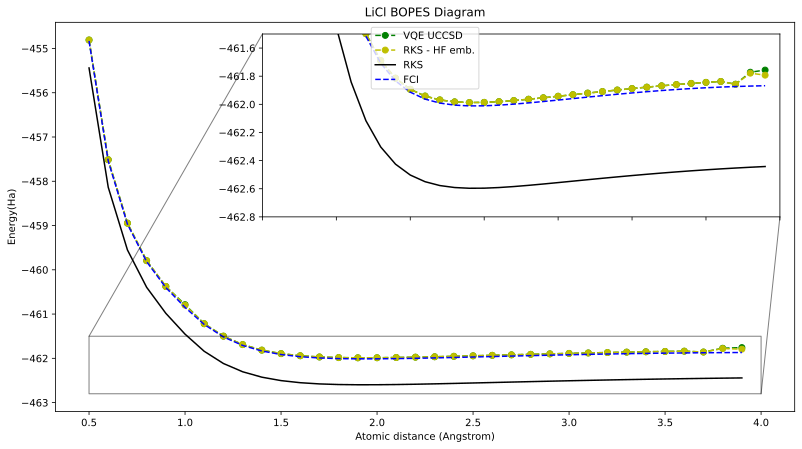

In [39]:
fig, ax=plt.subplots(1,1,figsize=(11,6))
fig.tight_layout()


ax.plot(RKS_dists, RKS_vqe_energies, '--go',label="VQE UCCSD")
ax.plot(RKS_dists, RKS_energies, '--yo',label="RKS - HF emb.")
ax.plot(RKS_dists, KS_energies, '-k',label="RKS")
ax.plot(RKS_dists, FCI_energies, '--b',label="FCI")
ax.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='LiCl BOPES Diagram')
#ax[0].set_xlim([0.7,4])
#ax[0].set_ylim([-148,-147])
ax.legend()

axins = ax.inset_axes([0.28, 0.5, 0.7, 0.47])
axins.plot(RKS_dists, RKS_vqe_energies, '--go',label="VQE UCCSD")
axins.plot(RKS_dists, RKS_energies, '--yo',label="RKS - HF emb.")
axins.plot(RKS_dists, KS_energies, '-k',label="RKS")
axins.plot(RKS_dists, FCI_energies, '--b',label="FCI")

x1, x2, y1, y2 = 0.5,4.0, -462.8, -461.5
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels([])
#axins.set_yticklabels([])

ax.indicate_inset_zoom(axins, edgecolor="black")

#ax[1].plot(sim_results['RKS_distances'], -delta_classic*10**2, '--bo',label="RHF-RKS")
#ax[1].plot(sim_results['RKS_VQE_distances'], -delta_vqe*10**2, '--go',label="VQE_EMB-VQE")
#ax[1].plot(sim_results['RKS_distances'], -delta_vqecl*10**2, '--yo',label="VQE-RKS")
#ax[1].plot(sim_results['RKS_VQE_distances'], -delta_vqefci*10**2, '--co',label="VQE-FCI")
#ax[1].plot(sim_results['RKS_distances'], [0]*len(sim_results['RKS_distances']), '-r',label="Delta=0")
#ax[1].plot(sim_results['RKS_distances'], np.subtract(RHF_copy,sim_results['RKS_energies'][0])*10**3, '--bo',label="RHF-RKS")
#ax[1].plot(distances, exact_dipole,'r' ,label="Exact Energy")
#ax[1].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy Delta (%)',title="Energy Deltas between methods ")
#ax[1].legend()

plt.subplots_adjust(wspace=0.17)
plt.show()

### Real HW

In [4]:
from qiskit_nature.runtime.vqe_client import VQERuntimeResult

def rt_callback(nfev, parameters, energy, stddev):
    display("Energy: {}, Std: {}".format(energy, stddev))
    clear_output(wait=True)
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)
    
def raw_callback(*args):
    # check if interim results, since both interim results (list) and final results (dict) are returned
    if type(args[1]) is list:
        job_id, (nfev, parameters, energy, stddev) = args
        display("Job_id: {} Energy: {}, Std: {}".format(job_id,energy, stddev))
        clear_output(wait=True)
        intermediate_info["nfev"].append(nfev)
        intermediate_info["parameters"].append(parameters)
        intermediate_info["energy"].append(energy)
        intermediate_info["stddev"].append(stddev)

def hw_solver(distances, mapper, optimizer, simp,backend):
    
    measurement_error_mitigation = True
    store_intermediate=True
        
    classic_energies = []
    rt_energies = []
    dists=[]
    
    intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
    }
                             
    for dist in distances:
        #Driver
        driver,propertiesr=make_driver(dist)
        #Qubit_Op
        qubit_op, num_particles, num_spin_orbitals, converter, problem = make_qubit_op(driver,mapper,simp)
        #Initial State
        init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
      #  try:
        #ansatz
        ansatz = EfficientSU2(num_qubits=qubit_op.num_qubits,su2_gates='ry', entanglement='linear', reps=3, initial_state=init_state)
    
        #VQE    
        # Set initial parameters of the ansatz
        initial_point = [0.01] * ansatz.num_parameters
            
        runtime_vqe = VQEClient(ansatz=ansatz,
                         optimizer=optimizer,
                         initial_point=initial_point,
                         provider=provider,
                         backend=backend,
                         shots=sh,
                         measurement_error_mitigation=measurement_error_mitigation,
                         callback=rt_callback,
                         store_intermediate=store_intermediate)

        rt_result = runtime_vqe.compute_minimum_eigenvalue(qubit_op)
        rt_energies.append(problem.interpret(rt_result).total_energies)
    
        #Classic Solver
        result_exact = exact_solver(problem, converter = converter)
        classic_energies.append(result_exact.total_energies)
      #  except:
        #    pass
        
    return classic_energies, rt_energies, dists 

def make_result(job):
    vqe_result = VQERuntimeResult()
    result=job.result()
    vqe_result.job_id = job.job_id
    vqe_result.cost_function_evals = result.get("cost_function_evals", None)
    vqe_result.eigenstate = result.get("eigenstate", None)
    vqe_result.eigenvalue = result.get("eigenvalue", None)
    aux_op_eigenvalues = result.get("aux_operator_eigenvalues", None)
    vqe_result.aux_operator_eigenvalues = aux_op_eigenvalues
    vqe_result.optimal_parameters = result.get("optimal_parameters", None)
    vqe_result.optimal_point = result.get("optimal_point", None)
    vqe_result.optimal_value = result.get("optimal_value", None)
    vqe_result.optimizer_evals = result.get("optimizer_evals", None)
    vqe_result.optimizer_time = result.get("optimizer_time", None)
    vqe_result.optimizer_history = result.get("optimizer_history", None)
    
    return vqe_result



In [41]:
IBMQ.load_account()
provider = IBMQ.get_provider(group='deployed')
backend_kol=provider.get_backend('ibmq_kolkata')
backend_mont=provider.get_backend('ibmq_montreal')


ibmqfactory.load_account:WARNING:2022-09-13 10:49:33,011: Credentials are already in use. The existing account in the session will be replaced.


Set parameters and run

In [162]:
#VQE CLIENT

from qiskit_nature.runtime import VQEClient
simp={"z2symmetry_reduction":True,
                 "two_qubit_reduction":True,
                 "freeze_core":False,
                 "HF_emb":True
}

distances = [0.5,1.0,1.5,2.0,2.5,3.0]
optimizer = SPSA(maxiter=50)
mapper=ParityMapper()


KS_energies, rt_energies, rt_dists = hw_solver(distances,mapper,optimizer,simp,backend_mont)
KS_energies

KeyboardInterrupt: 

In [157]:
rt_dists

[]

Running on Montreal

In [45]:
from qiskit_ibm_runtime import QiskitRuntimeService

simp={"z2symmetry_reduction":True,
                 "two_qubit_reduction":True,
                 "freeze_core":False,
                 "HF_emb":True
}

service = QiskitRuntimeService()
options = {"backend_name" : "ibmq_montreal"}
distances = np.arange(0.5,3,.25)
optimizer = SPSA(maxiter=100)
mapper=ParityMapper()
qubit_ops=[]
problems=[]
ansatze=[]

job_ids=[]

In [46]:
#VQE RUNTIME


for dist in distances:
    
    driver,propertiesr=make_driver(dist)
    #Qubit_Op
    qubit_op, num_particles, num_spin_orbitals, converter, problem = make_qubit_op(driver,mapper,simp)
    problems.append(problem)
    qubit_ops.append(qubit_op)
    #X_D=converter.convert(second_q_ops[4],num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)
    #Y_D=converter.convert(second_q_ops[5],num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)
    #Z_D=converter.convert(second_q_ops[6],num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)
    #Initial State
    init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
    #ansatz
    ansatze.append(EfficientSU2(num_qubits=qubit_op.num_qubits,su2_gates='ry', entanglement='linear', reps=3, initial_state=init_state))


In [44]:
len(qubit_ops)

10

In [53]:
from qiskit.transpiler import Layout
job_ids=[]
options = {"backend_name" : "ibmq_kolkata"}  
for i,qubit_op in enumerate(qubit_ops):
    initial_point = np.random.uniform(-np.pi, np.pi, len(ansatze[i].parameters))
    #initial_layout=[22,19,16,14,11,8,5,3,2,1,4,7]#{0:13,1:14,2:11,3:8,4:5,5:3,6:2,}           
    vqe_inputs = {
        "ansatz": ansatze[i],
        "operator": qubit_op,
        "optimizer": optimizer,  
        "initial_parameters": initial_point,
        #"initial_layout": initial_layout,
        "measurement_error_mitigation": True,
        "shots": 4096,
    }

    intermediate_info = {"nfev": [], "parameters": [], "energy": [], "stddev": []}
    
    job= service.run(
    program_id="vqe", inputs=vqe_inputs, options=options, callback=raw_callback)
    job_ids.append(job.job_id)

#write_list(job_ids,'LiCl Calculated energies/LiCl_job_ids_mem')
write_list(job_ids,'LiCl Calculated energies/LiCl_job_ids_mem_2')
#write_list(job_ids,'LiCl Calculated energies/LiCl_job_ids')

Done writing list into a binary file


In [56]:
jobs=read('LiCl Calculated energies/LiCl_job_ids_mem')
jobs

['ccgus4h9isti69vsme60',
 'ccgus4upbtmrgftl33qg',
 'ccgus518l4hnj1ikqgbg',
 'ccgus5ab5p7deggp65qg',
 'ccgus5mpbtmrgftl33t0',
 'ccgus5k8v5tbg880g6v0',
 'ccgus5p9isti69vsme9g',
 'ccgus66pbtmrgftl33v0',
 'ccgus63q8rlc0d3cdbag',
 'ccgus699isti69vsmedg']

In [54]:
#jobs=read('LiCl Calculated energies/LiF_job_ids')
jobs=read('LiCl Calculated energies/LiCl_job_ids_mem_2')

distances = np.arange(0.5,1.0,.25)
dist2= np.arange(1.25,2.5,.25)
distances=np.append(distances,dist2)
results=[]
kolk_energies=[]
for i in range(0,2):
    results.append(make_result(service.job(jobs[i])))
    kolk_energies.append(problems[i].interpret(results[i]).total_energies)
    
for i in range(3,len(jobs)-2):
    results.append(make_result(service.job(jobs[i])))
    kolk_energies.append(problems[i].interpret(results[i-1]).total_energies)

KeyboardInterrupt: 

In [11]:
print(service.job('cc7rgl2vb7prqi8mt5b0').job_id)

cc7rgl2vb7prqi8mt5b0


In [26]:
kolk_energies

[array([-449.9498364+0.j]),
 array([-458.06261657+0.j]),
 array([-455.69617692+0.j]),
 array([-457.18982332+0.j]),
 array([-457.7285796+0.j]),
 array([-446.12808722+0.j]),
 array([-454.54287237+0.j])]

In [37]:
distances = np.arange(0.5,1.0,.25)
dist2= np.arange(1.25,2.5,.25)
distances=np.append(distances,dist2)
results_dict={'rt_energies':kolk_energies,
              'rt_dists':distances
             }
write_dict(results_dict, 'LiCl Calculated energies/LiCl_kolk_results_mem')
#write_dict(results_dict, 'LiCl Calculated energies/LiCl_mont_results')

Done writing dict into a binary file


In [38]:
results_dict['rt_dists']

array([0.5 , 0.75, 1.25, 1.5 , 1.75, 2.  , 2.25])

In [36]:
distances

array([0.5 , 0.75, 1.25, 1.5 , 1.75, 2.  , 2.25])

### PYSCF

In [29]:
import pyscf
from pyscf import gto, scf, cc, fci, dft
distances=np.arange(0.5,4,0.1)
FCI_energies=[]
KS_energies=[]
for dist in distances:
    mol = pyscf.M(
        atom = 'Li 0 0 0; Cl 0 0 '+str(dist),  # in Angstrom
        basis = 'sto-3g',
        symmetry = True,
        )
    myks = mol.RKS().run()
    mf_ks = dft.RKS(mol)
    mf_ks.xc = 'b3lyp' # default
    mf_ks = mf_ks.newton() # second-order algortihm
    #myccisd = mf.CISD().run()
    #print('UCISD correlation energy', myccisd.e_corr)
    #cisolver = fci.FCI(mol, mf.mo_coeff)
    #print('E(FCI) = %.12f' % cisolver.kernel()[0])
    KS_energies.append(mf_ks.kernel())

#
# create an FCI solver based on the SCF object
#
    cisolver = pyscf.fci.FCI(myks)
    FCI_energies.append(cisolver.kernel()[0])

converged SCF energy = -453.873397459481
converged SCF energy = -455.440221798497
converged SCF energy = -456.560580771935
converged SCF energy = -458.136021319723
converged SCF energy = -457.972790645614
converged SCF energy = -459.551098438184
converged SCF energy = -458.816871380036
converged SCF energy = -460.395096560197
converged SCF energy = -459.404054586652
converged SCF energy = -460.983222504902
SCF not converged.
SCF energy = -459.31808438546
converged SCF energy = -461.453387313176
converged SCF energy = -460.258034478402
converged SCF energy = -461.841180215873
converged SCF energy = -460.530313512883
converged SCF energy = -462.116503894942
converged SCF energy = -460.714398441992
converged SCF energy = -462.302984672885
converged SCF energy = -460.834684759072
converged SCF energy = -462.425136665764
converged SCF energy = -460.910702812411
converged SCF energy = -462.502569551611
converged SCF energy = -460.95708426278
converged SCF energy = -462.549923579414
converged

### Results

In [39]:
rt_results_mem=read('LiCl Calculated energies/LiCl_kolk_results_mem')
#rt_results=read('LiCl Calculated energies/LiCl_mont_results')
sim_results=read('LiCl Calculated energies/LiCl_sim_results')

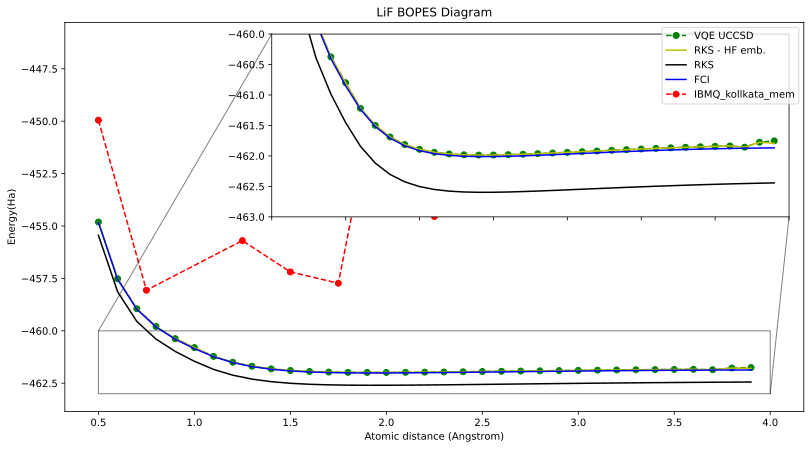

In [44]:
distances=np.arange(0.5,4,0.1)

fig, ax=plt.subplots(1,1,figsize=(11,6))
fig.tight_layout()


ax.plot(sim_results['RKS_dists'], sim_results['RKS_VQE_energies'], '--go',label="VQE UCCSD")
ax.plot(sim_results['RKS_dists'], sim_results['RKS_energies'], '-y',label="RKS - HF emb.")
ax.plot(distances, KS_energies, '-k',label="RKS")
ax.plot(distances, FCI_energies, '-b',label="FCI")
#ax.plot(rt_results['rt_dists'], rt_results['rt_energies'], '--co',label="IBMQ_Montreal.")
ax.plot(rt_results_mem['rt_dists'], rt_results_mem['rt_energies'], '--ro',label="IBMQ_kollkata_mem")
ax.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='LiF BOPES Diagram')
#ax[0].set_xlim([0.7,4])
#ax[0].set_ylim([-148,-147])
ax.legend()

axins = ax.inset_axes([0.28, 0.5, 0.7, 0.47])
axins.plot(sim_results['RKS_dists'], sim_results['RKS_VQE_energies'], '--go',label="VQE UCCSD")
axins.plot(sim_results['RKS_dists'], sim_results['RKS_energies'], '-y',label="RKS - HF emb.")
axins.plot(distances, KS_energies, '-k',label="RKS")
axins.plot(distances, FCI_energies, '-b',label="FCI")

x1, x2, y1, y2 = 0.5,4.0, -463, -460
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels([])
#axins.set_yticklabels([])

ax.indicate_inset_zoom(axins, edgecolor="black")

#ax[1].plot(sim_results['RKS_distances'], -delta_classic*10**2, '--bo',label="RHF-RKS")
#ax[1].plot(sim_results['RKS_VQE_distances'], -delta_vqe*10**2, '--go',label="VQE_EMB-VQE")
#ax[1].plot(sim_results['RKS_distances'], -delta_vqecl*10**2, '--yo',label="VQE-RKS")
#ax[1].plot(sim_results['RKS_VQE_distances'], -delta_vqefci*10**2, '--co',label="VQE-FCI")
#ax[1].plot(sim_results['RKS_distances'], [0]*len(sim_results['RKS_distances']), '-r',label="Delta=0")
#ax[1].plot(sim_results['RKS_distances'], np.subtract(RHF_copy,sim_results['RKS_energies'][0])*10**3, '--bo',label="RHF-RKS")
#ax[1].plot(distances, exact_dipole,'r' ,label="Exact Energy")
#ax[1].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy Delta (%)',title="Energy Deltas between methods ")
#ax[1].legend()

plt.subplots_adjust(wspace=0.17)
plt.show()

<h2>Li2O</h2>

In [21]:
#Define Molecule
molecule = Molecule(
             # coordinates in Angstrom
                    geometry=[
                            ["Li", [1.7147*np.sin(np.pi/2) ,-1.7147*np.cos(np.pi/2),0]],
                            ["Li", [-1.7147*np.sin(np.pi/2) ,-1.7147*np.cos(np.pi/2),0]],
                            ['O',[0.0,0.0,0.0]]
                            ],
                     multiplicity=1,  # = 2*spin + 1
                     charge=0
                    )
    
#Set driver
driver = ElectronicStructureMoleculeDriver(
    molecule=molecule,
    basis="sto3g",
    driver_type=ElectronicStructureDriverType.PYSCF,
    )

#Get properties
properties = driver.run()
    
#particle_number = problem.grouped_property_transformed.get_property("ParticleNumber")
num_a_electrons = properties.get_property("ParticleNumber").num_alpha
num_b_electrons = properties.get_property("ParticleNumber").num_beta
num_particles=properties.get_property("ParticleNumber").num_particles

num_spin_orbitals =int(properties.get_property("ParticleNumber").num_spin_orbitals)

rep_energy = properties.get_property("ElectronicEnergy").nuclear_repulsion_energy
    
# Check the occupation of the spin orbitals
PN_property = properties.get_property("ParticleNumber")

# Define the active space
# (selected automatically around the HOMO and LUMO, ordered by energy)
transformer = ActiveSpaceTransformer(
    num_electrons=(2,2), #Electrons in active space
    num_molecular_orbitals=4 #Orbitals in active space
    #,active_orbitals=np.arange(1,11,1)
)
    
#Define the problem

problem = ElectronicStructureProblem(driver)
    
second_q_ops = problem.second_q_ops() # Get 2nd Quant OP. This calls driver.run() internally
    
num_spin_orbitals = problem.num_spin_orbitals
num_particles = problem.num_particles
    
hamiltonian = second_q_ops[0] #Set Hamiltonian
mapper=ParityMapper()

#Get Pauli OP
#converter = QubitConverter(mapper)
#qubit_op = converter.convert(hamiltonian)
    
#Symmetries
#sym=Z2Symmetries.find_Z2_symmetries(qubit_op)

converter = QubitConverter(mapper)
    
#Final OP
#qubit_op = converter.convert(hamiltonian,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)

In [11]:
print(properties)

ElectronicStructureDriverResult:
	DriverMetadata:
		Program: PYSCF
		Version: 2.0.1
		Config:
			atom=Li 1.7147 -1.0499509332489832e-16 0;Li -1.7147 -1.0499509332489832e-16 0;O 0.0 0.0 0.0
			unit=Angstrom
			charge=0
			spin=0
			basis=sto3g
			method=rhf
			conv_tol=1e-09
			max_cycle=50
			init_guess=minao
			max_memory=4000
			
	ElectronicBasisTransform:
		Initial basis: atomic
		Final basis: molecular
		Alpha coefficients:
		[0, 0] = 0.00011683726481790031
		[0, 1] = -0.699313057335438
		[0, 2] = 0.7002611930718554
		[0, 3] = -0.058169683786367846
		[0, 4] = -0.12057944881245988
		[0, 5] = 1.0450311261326597e-17
		[0, 6] = -8.199672488015446e-18
		[0, 7] = -0.17607825525068277
		[0, 8] = 0.15842988391613788
		[0, 9] = -5.583074057268908e-16
		[0, 10] = 2.0073509711188225e-17
		[0, 11] = -4.906083973525391e-16
		[0, 12] = -2.7744689996932743e-16
		[0, 13] = 0.07395162198338241
		[0, 14] = 0.10128094244944563
		[1, 0] = -0.0021713213484606452
		[1, 1] = -0.030482318697772553
		[1, 2

In [19]:
qubit_op = converter.convert(hamiltonian,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)

In [20]:
qubit_op.num_qubits

8

In [27]:
transformer = ActiveSpaceTransformer(
    num_electrons=(2,2), #Electrons in active space
    num_molecular_orbitals=6 #Orbitals in active space
    #,active_orbitals=np.arange(1,9,1)
)

problem = ElectronicStructureProblem(driver, [transformer])

second_q_ops = problem.second_q_ops()
hamiltonian = second_q_ops[0]
mapper=ParityMapper()
converter = QubitConverter(mapper
                                ,two_qubit_reduction=True
                                ,z2symmetry_reduction='auto'
                                #,z2symmetry_reduction=problem.symmetry_sector_locator(sym,converter)
                              )
qubit_op = converter.convert(hamiltonian,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)
qubit_op.num_qubits

8

In [58]:
#Functions

def make_driver(dist,angle):
    
    
    #Define Molecule
    molecule = Molecule(
             # coordinates in Angstrom
                    geometry=[
                            ["Li", [dist*np.sin(angle) ,-dist*np.cos(angle),0]],
                            ["Li", [-dist*np.sin(angle) ,-dist*np.cos(angle),0]],
                            ['O',[0.0,0.0,0.0]]
                            ],
                     multiplicity=1,  # = 2*spin + 1
                     charge=0
                    )
    
    #Set driver
    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF,
        method=MethodType.RKS
        
    )

    #Get properties
    properties = driver.run()
    

    return driver, properties


def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)

def make_qubit_op(driver,mapper, simplifications):

    if simplifications["HF_emb"]==True and simplifications["freeze_core"]==True:
        transformer = ActiveSpaceTransformer(
            num_electrons=(2,2), #Electrons in active space
            num_molecular_orbitals=6, #Orbitals in active space
        )

        problem = ElectronicStructureProblem(driver,[transformer,FreezeCoreTransformer(freeze_core=True)])
    
    elif simplifications["HF_emb"]==True and simplifications["freeze_core"]==False:
        
        transformer = ActiveSpaceTransformer(
            num_electrons=(2,2), #Electrons in active space
            num_molecular_orbitals=6, #Orbitals in active space
        )

        problem = ElectronicStructureProblem(driver,[transformer])
         
    elif simplifications["HF_emb"]==False and simplifications["freeze_core"]==True:
        problem = ElectronicStructureProblem(driver,[FreezeCoreTransformer(freeze_core=True)])
    
    else:
         problem = ElectronicStructureProblem(driver)
        
    
    second_q_ops = problem.second_q_ops() # Get 2nd Quant OP. This calls driver.run() internally
    
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles
    
    hamiltonian = second_q_ops[0] #Set Hamiltonian

    #Get Pauli OP
    if simplifications["z2symmetry_reduction"]==True and simplifications["two_qubit_reduction"]==True:
        converter = QubitConverter(mapper,two_qubit_reduction=True, z2symmetry_reduction='auto')
                              
    elif simplifications["z2symmetry_reduction"]==False and simplifications["two_qubit_reduction"]==True:
        converter = QubitConverter(mapper,two_qubit_reduction=True)
        
    elif simplifications["z2symmetry_reduction"]==True and simplifications["two_qubit_reduction"]==False:
        converter = QubitConverter(mapper,z2symmetry_reduction='auto')
                                   
    else:
        converter = QubitConverter(mapper)
        
        
    
    #Final OP
    qubit_op = converter.convert(hamiltonian,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)
    
    
    return qubit_op, num_particles, num_spin_orbitals, converter, problem
                                   
def exact_solver(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

from qiskit_nature.runtime.vqe_client import VQERuntimeResult

def make_result(VQEResult):
    vqe_result = VQERuntimeResult()
    result=VQEResult
    #vqe_result.job_id = job.job_id
    vqe_result.cost_function_evals = result.cost_function_evals
    vqe_result.eigenstate = result.eigenstate
    vqe_result.eigenvalue = result.eigenvalue
    aux_op_eigenvalues = result.aux_operator_eigenvalues
    vqe_result.aux_operator_eigenvalues = aux_op_eigenvalues
    vqe_result.optimal_parameters = result.optimal_parameters
    vqe_result.optimal_point = result.optimal_point
    vqe_result.optimal_value = result.optimal_value
    vqe_result.optimizer_evals = result.optimizer_evals
    vqe_result.optimizer_time = result.optimizer_time
    #vqe_result.optimizer_history = result.get("optimizer_history", None)
    
    return vqe_result

def sim_solver(distances, angle, mapper, optimizer, simp):
        
    classic_energies = []
    vqe_energies = []
    avqe_energies=[]
    dists=[]
                             
    for dist in distances:
        #Driver
        driver,propertiesr=make_driver(dist,angle)
        #Qubit_Op
        qubit_op, num_particles, num_spin_orbitals, converter, problem = make_qubit_op(driver,mapper,simp)
        #Initial State
        init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
        #ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
        ansatz=EfficientSU2(num_qubits=qubit_op.num_qubits,su2_gates='ry', entanglement='linear', reps=3, initial_state=init_state)
    
        #VQE
  

        counts = []
        values = []
        params = []
        deviation = []
            
    
        # Set initial parameters of the ansatz
        initial_point = [0.01] * ansatz.num_parameters
        
    
            #VQE Solver
        vqe_factory=VQEUCCFactory(quantum_instance=qi
                         ,optimizer=optimizer
                         ,initial_point=initial_point
                         ,ansatz=ansatz
                         ,callback=callback
                        )
    
            #Normal VQE UCCSD
        #solver_vqe=GroundStateEigensolver(converter,vqe_factory)
        

        #vqe_calc=solver_vqe.solve(problem)
        vqe=VQE(ansatz=ansatz,
                     optimizer=optimizer,
                     initial_point=initial_point,
                     #gradient=NaturalGradient(grad_method='lin_comb',     qfi_method='lin_comb_full', regularization='ridge'),
                     callback=callback,
                     quantum_instance=qi)
        vqe_calc=vqe.compute_minimum_eigenvalue(qubit_op)
        vqe_result=make_result(vqe_calc)
        interp=problem.interpret(vqe_result)
        
        vqe_energies.append(interp.total_energies)
    
            #ADAPT VQE
            #solver_avqe = AdaptVQE(converter,vqe_factory,max_iterations=20)

            #avqe_calc=solver_avqe.solve(problem)
            #avqe_energies.append(avqe_calc.total_energies)
            
            
            #Classic Solver
        result_exact = exact_solver(problem, converter = converter)
        classic_energies.append(result_exact.total_energies)
            
        dists.append(dist)
       
        
    return classic_energies, vqe_energies, avqe_energies, dists

### PySCF

In [16]:
import pyscf
from pyscf import gto, scf, cc, fci, dft
distances=np.arange(0.5,4,0.1)
FCI_energies=[]
KS_energies=[]
HF_energies=[]
angle=np.pi/2
for dist in distances:
    mol = pyscf.M(
        atom = 'O 0 0 0;Li '+str(dist*np.sin(angle))+' '+str(-dist*np.cos(angle))+' 0; Li '+str(-dist*np.sin(angle))+' '+str(-dist*np.cos(angle))+' 0',  # in Angstrom
        basis = 'sto-3g',
        symmetry = True,
        )
    myks = mol.RKS().run()
    mf_ks = dft.RKS(mol)
    mf_ks.xc = 'b3lyp' # default
    mf_ks = mf_ks.newton() # second-order algortihm
    rhf= scf.RHF(mol)
    HF_energies.append(rhf.kernel())
    #myccisd = mf.CISD().run()
    #print('UCISD correlation energy', myccisd.e_corr)
    #cisolver = fci.FCI(mol, mf.mo_coeff)
    #print('E(FCI) = %.12f' % cisolver.kernel()[0])
    KS_energies.append(mf_ks.kernel())

#
# create an FCI solver based on the SCF object
#
    #cisolver = pyscf.fci.FCI(myks)
    #FCI_energies.append(cisolver.kernel()[0])

SCF not converged.
SCF energy = -80.9102314567275
converged SCF energy = -81.145562650514
converged SCF energy = -81.6102140049431
converged SCF energy = -83.69603514224
converged SCF energy = -83.9621287480009
converged SCF energy = -84.4096476634998
converged SCF energy = -85.3277002979619
converged SCF energy = -85.6218716338209
converged SCF energy = -86.0546423564138
SCF not converged.
SCF energy = -86.154445936786
converged SCF energy = -86.6253360821319
converged SCF energy = -87.0633617715494
converged SCF energy = -87.0639335330216
converged SCF energy = -87.2645977839279
converged SCF energy = -87.7884282680662
converged SCF energy = -87.5487534412572
converged SCF energy = -87.792080413021
converged SCF energy = -88.2875468612473
converged SCF energy = -87.8696457950201
converged SCF energy = -88.157418498384
converged SCF energy = -88.6232548180833
converged SCF energy = -88.073102942168
converged SCF energy = -88.3792027889838
converged SCF energy = -88.8360412846881
conve

### Sims

In [35]:
from qiskit.providers.fake_provider import FakeManila, FakeNairobi

#Noisy simulator
backend_aer = AerSimulator(method='density_matrix',device='CPU')
device_backend=FakeNairobi()
device = AerSimulator.from_backend(device_backend)
noise_model = None
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
basis_gates = noise_model.basis_gates

In [64]:
simp={"z2symmetry_reduction":True,
                 "two_qubit_reduction":True,
                 "freeze_core":False,
                 "HF_emb":True
}

distances = np.arange(0.5, 4, 0.1)
angle=np.pi/2
optimizer = SLSQP(maxiter=100)
mapper=ParityMapper()

seed = 62
algorithm_globals.random_seed = seed
qi=backend_stv
#qi= QuantumInstance(backend_aer, seed_simulator=seed, seed_transpiler=seed, #Noisy Quantum Instance
#                          coupling_map=coupling_map,noise_model=noise_model,
#                          measurement_error_mitigation_cls=CompleteMeasFitter)

In [65]:
counts = []
values = []
params = []
deviation = []

RKS_energies, RKS_vqe_energies, RKS_avqe_energies, RKS_dists = sim_solver(distances,angle,mapper,optimizer,simp)
RKS_energies

[array([-81.20235419+0.j]),
 array([-83.99551289+0.j]),
 array([-85.64274638+0.j]),
 array([-86.64730281+0.j]),
 array([-87.3276972+0.j]),
 array([-87.79478267+0.j]),
 array([-88.15567607+0.j]),
 array([-88.37492717+0.j]),
 array([-88.4962562+0.j]),
 array([-88.55499814+0.j]),
 array([-88.57580925+0.j]),
 array([-88.56894129+0.j]),
 array([-88.54612288+0.j]),
 array([-88.51363185+0.j]),
 array([-88.47550222+0.j]),
 array([-88.43434769+0.j]),
 array([-88.39188947+0.j]),
 array([-88.34927399+0.j]),
 array([-88.30730334+0.j]),
 array([-88.26655704+0.j]),
 array([-84.64806145+0.j]),
 array([-88.28425988+0.j]),
 array([-88.22743799+0.j]),
 array([-82.83409941+0.j]),
 array([-83.03108241+0.j]),
 array([-83.28926596+0.j]),
 array([-84.88294919+0.j]),
 array([-82.95810617+0.j]),
 array([-83.29807672+0.j]),
 array([-82.63324184+0.j]),
 array([-82.63746572+0.j]),
 array([-82.22629058+0.j]),
 array([-82.74255227+0.j]),
 array([-88.07116347+0.j]),
 array([-87.80946992+0.j])]

In [66]:
RKS_vqe_energies

[array([-81.1981126+0.j]),
 array([-83.9922141+0.j]),
 array([-85.18962339+0.j]),
 array([-86.63311131+0.j]),
 array([-87.27005293+0.j]),
 array([-87.69836474+0.j]),
 array([-88.154843+0.j]),
 array([-88.37406322+0.j]),
 array([-88.4953558+0.j]),
 array([-88.55413376+0.j]),
 array([-88.57323962+0.j]),
 array([-88.56624538+0.j]),
 array([-88.54344425+0.j]),
 array([-88.51091107+0.j]),
 array([-88.47212834+0.j]),
 array([-88.43152416+0.j]),
 array([-88.15301965+0.j]),
 array([-88.34647938+0.j]),
 array([-88.30455869+0.j]),
 array([-88.26331288+0.j]),
 array([-84.60739583+0.j]),
 array([-88.15499244+0.j]),
 array([-88.05788703+0.j]),
 array([-82.53990564+0.j]),
 array([-82.72085616+0.j]),
 array([-83.26886784+0.j]),
 array([-84.83078214+0.j]),
 array([-82.82424829+0.j]),
 array([-83.07698061+0.j]),
 array([-82.57698821+0.j]),
 array([-82.61981927+0.j]),
 array([-81.70522202+0.j]),
 array([-82.73869037+0.j]),
 array([-87.74626427+0.j]),
 array([-87.78256789+0.j])]

In [67]:
results_dict={'RKS_VQE_energies':RKS_vqe_energies,
             'RKS_energies': RKS_energies,
             'RKS_dists':distances,
}

write_dict(results_dict, 'Li2O Calculated energies/Li2O_sim_results')

Done writing dict into a binary file


### Results

In [5]:
#rt_results_mem=read('LiF Calculated energies/LiF_kolk_results_mem')
#rt_results=read('LiF Calculated energies/LiF_kolk_results')
sim_results=read('Li2O Calculated energies/Li2O_sim_results')

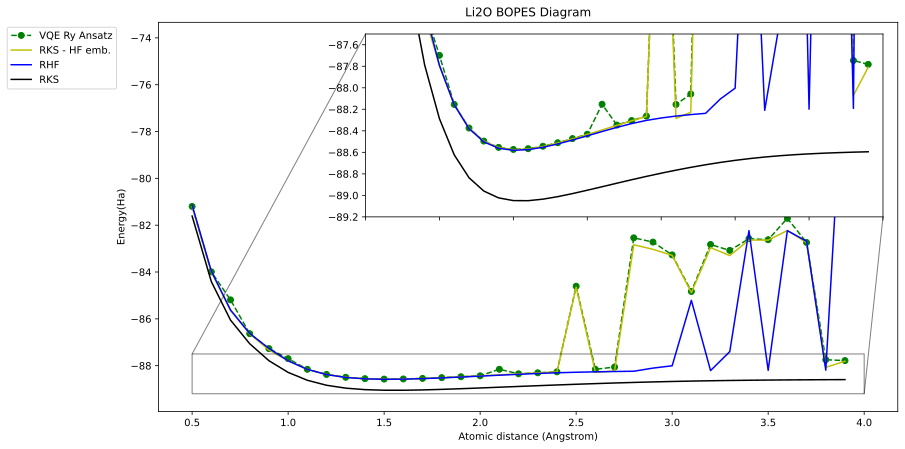

In [19]:
distances=np.arange(0.5,4,0.1)

fig, ax=plt.subplots(1,1,figsize=(11,6))
fig.tight_layout()


ax.plot(sim_results['RKS_dists'], sim_results['RKS_VQE_energies'], '--go',label="VQE Ry Ansatz")
ax.plot(sim_results['RKS_dists'], sim_results['RKS_energies'], '-y',label="RKS - HF emb.")
ax.plot(distances, HF_energies, '-b',label="RHF")
ax.plot(distances, KS_energies, '-k',label="RKS")
#ax.plot(distances, FCI_energies, '-b',label="FCI")
#ax.plot(rt_results['rt_dists'], rt_results['rt_energies'], '--co',label="IBMQ_Montreal.")
#ax.plot(rt_results_mem['rt_dists'], rt_results_mem['rt_energies'], '--ro',label="IBMQ_Montreal_mem")
ax.set(xlabel='Atomic distance (Angstrom)',ylabel='Energy(Ha)',title='Li2O BOPES Diagram')
#ax[0].set_xlim([0.7,4])
#ax[0].set_ylim([-148,-147])
ax.legend(bbox_to_anchor=(-.05,1))


axins = ax.inset_axes([0.28, 0.5, 0.7, 0.47])
axins.plot(sim_results['RKS_dists'], sim_results['RKS_VQE_energies'], '--go',label="VQE UCCSD")
axins.plot(sim_results['RKS_dists'], sim_results['RKS_energies'], '-y',label="RKS - HF emb.")
axins.plot(distances, HF_energies, '-b',label="RHF")
axins.plot(distances, KS_energies, '-k',label="RKS")
#axins.plot(distances, FCI_energies, '-b',label="FCI")

x1, x2, y1, y2 = 0.5,4.0, -89.2, -87.5
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_xticklabels([])
#axins.set_yticklabels([])

ax.indicate_inset_zoom(axins, edgecolor="black")

#ax[1].plot(sim_results['RKS_distances'], -delta_classic*10**2, '--bo',label="RHF-RKS")
#ax[1].plot(sim_results['RKS_VQE_distances'], -delta_vqe*10**2, '--go',label="VQE_EMB-VQE")
#ax[1].plot(sim_results['RKS_distances'], -delta_vqecl*10**2, '--yo',label="VQE-RKS")
#ax[1].plot(sim_results['RKS_VQE_distances'], -delta_vqefci*10**2, '--co',label="VQE-FCI")
#ax[1].plot(sim_results['RKS_distances'], [0]*len(sim_results['RKS_distances']), '-r',label="Delta=0")
#ax[1].plot(sim_results['RKS_distances'], np.subtract(RHF_copy,sim_results['RKS_energies'][0])*10**3, '--bo',label="RHF-RKS")
#ax[1].plot(distances, exact_dipole,'r' ,label="Exact Energy")
#ax[1].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy Delta (%)',title="Energy Deltas between methods ")
#ax[1].legend()

plt.subplots_adjust(wspace=0.17)
plt.show()

### Real HW

<h2>Li3N</h2>

In [50]:
#Define Molecule
molecule = Molecule(
             # coordinates in Angstrom
                    geometry=[
                            ["Li", [0.58 ,0.96 ,0.33]],
                        
                            ["O", [0.0 ,0.0 ,0.0]],
                            ["O", [0.0 ,0.0 ,0.0]],
                            ["O", [0.0 ,0.0 ,0.0]],
                            ["O", [0.0 ,0.0 ,0.0]],
                        
                            ["I", [0.15 ,0.71,0.43]]
                            ],
                     multiplicity=1,  # = 2*spin + 1
                     charge=0
                    )
    
#Set driver
driver = ElectronicStructureMoleculeDriver(
    molecule=molecule,
    basis="sto3g",
    driver_type=ElectronicStructureDriverType.PYSCF,
    )

#Get properties
properties = driver.run()
    
#particle_number = problem.grouped_property_transformed.get_property("ParticleNumber")
num_a_electrons = properties.get_property("ParticleNumber").num_alpha
num_b_electrons = properties.get_property("ParticleNumber").num_beta
num_particles=properties.get_property("ParticleNumber").num_particles

num_spin_orbitals =int(properties.get_property("ParticleNumber").num_spin_orbitals)

rep_energy = properties.get_property("ElectronicEnergy").nuclear_repulsion_energy
    
# Check the occupation of the spin orbitals
PN_property = properties.get_property("ParticleNumber")

# Define the active space
# (selected automatically around the HOMO and LUMO, ordered by energy)
transformer = ActiveSpaceTransformer(
    num_electrons=(8,8), #Electrons in active space
    num_molecular_orbitals=9 #Orbitals in active space
    #,active_orbitals=np.arange(1,11,1)
)
    
#Define the problem

problem = ElectronicStructureProblem(driver)
    
second_q_ops = problem.second_q_ops() # Get 2nd Quant OP. This calls driver.run() internally
    
num_spin_orbitals = problem.num_spin_orbitals
num_particles = problem.num_particles
    
hamiltonian = second_q_ops[0] #Set Hamiltonian
mapper=ParityMapper()

#Get Pauli OP
#converter = QubitConverter(mapper)
#qubit_op = converter.convert(hamiltonian)
    
#Symmetries
#sym=Z2Symmetries.find_Z2_symmetries(qubit_op)

converter = QubitConverter(mapper)
    
#Final OP
#qubit_op = converter.convert(hamiltonian,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)

In [ ]:
print(properties)

<h2>LiI</h2>

In [2]:
#Define Molecule
molecule = Molecule(
             # coordinates in Angstrom
                    geometry=[
                            ["Li", [0.0 ,0.0 ,0.0]],
                            ["I", [0.0 ,0.0,2.3919]]
                            ],
                     multiplicity=1,  # = 2*spin + 1
                     charge=0
                    )
    
#Set driver
driver = ElectronicStructureMoleculeDriver(
    molecule=molecule,
    basis="sto3g",
    driver_type=ElectronicStructureDriverType.PYSCF,
    )

#Get properties
properties = driver.run()
    
#particle_number = problem.grouped_property_transformed.get_property("ParticleNumber")
num_a_electrons = properties.get_property("ParticleNumber").num_alpha
num_b_electrons = properties.get_property("ParticleNumber").num_beta
num_particles=properties.get_property("ParticleNumber").num_particles

num_spin_orbitals =int(properties.get_property("ParticleNumber").num_spin_orbitals)

rep_energy = properties.get_property("ElectronicEnergy").nuclear_repulsion_energy
    
# Check the occupation of the spin orbitals
PN_property = properties.get_property("ParticleNumber")

# Define the active space
# (selected automatically around the HOMO and LUMO, ordered by energy)
transformer = ActiveSpaceTransformer(
    num_electrons=(8,8), #Electrons in active space
    num_molecular_orbitals=9 #Orbitals in active space
    #,active_orbitals=np.arange(1,11,1)
)
    
#Define the problem

problem = ElectronicStructureProblem(driver)
    
second_q_ops = problem.second_q_ops() # Get 2nd Quant OP. This calls driver.run() internally
    
num_spin_orbitals = problem.num_spin_orbitals
num_particles = problem.num_particles
    
hamiltonian = second_q_ops[0] #Set Hamiltonian
mapper=ParityMapper()

#Get Pauli OP
#converter = QubitConverter(mapper)
#qubit_op = converter.convert(hamiltonian)
    
#Symmetries
#sym=Z2Symmetries.find_Z2_symmetries(qubit_op)

converter = QubitConverter(mapper)
    
#Final OP
#qubit_op = converter.convert(hamiltonian,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)

In [4]:
print(properties)

ElectronicStructureDriverResult:
	DriverMetadata:
		Program: PYSCF
		Version: 2.0.1
		Config:
			atom=Li 0.0 0.0 0.0;I 0.0 0.0 2.3919
			unit=Angstrom
			charge=0
			spin=0
			basis=sto3g
			method=rhf
			conv_tol=1e-09
			max_cycle=50
			init_guess=minao
			max_memory=4000
			
	ElectronicBasisTransform:
		Initial basis: atomic
		Final basis: molecular
		Alpha coefficients:
		[0, 0] = 1.425546518150628e-07
		[0, 1] = 0.0001318337635152263
		[0, 2] = 1.4082510467986002e-05
		[0, 3] = -3.2707722878637084e-18
		[0, 4] = -6.052374161317264e-18
		[0, 5] = -0.0005465891667596407
		[0, 6] = 0.00011283631190461612
		[0, 7] = -1.901521993397859e-16
		[0, 8] = -7.024005795909582e-18
		[0, 9] = 0.0001094167833620828
		[0, 10] = 3.916467827924768e-17
		[0, 11] = -1.4607981005207942e-17
		[0, 12] = -7.960035251011681e-17
		[0, 13] = -5.269657884752533e-15
		[0, 14] = -0.00032227880161142064
		[0, 15] = 0.00018546557240546038
		[0, 16] = -4.133154744889036e-18
		[0, 17] = 2.2450772256416617e-17
		[0

### No Simplification

In [8]:
qubit_op.num_qubits

64

In [4]:
r_test = read_list('LiI_qubit_ops/pure/pure_list_op')
qubit_op=PauliSumOp.from_list(r_test)
qubit_op.num_qubits

FileNotFoundError: [Errno 2] No such file or directory: 'LiI_qubit_ops/pure/pure_list_op'

### Freeze Core

In [11]:
r_test = read_list('LiI_qubit_ops/freeze/freeze_list_op')
qubit_op=PauliSumOp.from_list(r_test)
qubit_op.num_qubits

26

In [ ]:
transformer = ActiveSpaceTransformer(
    num_electrons=(7,7), #Electrons in active space
    num_molecular_orbitals=8 #Orbitals in active space
    ,active_orbitals=np.arange(1,9,1)
)

problem = ElectronicStructureProblem(driver, [FreezeCoreTransformer(freeze_core=True)])

second_q_ops = problem.second_q_ops()
hamiltonian = second_q_ops[0]
mapper=ParityMapper()
converter = QubitConverter(mapper
                                #,two_qubit_reduction=True
                                #,z2symmetry_reduction='auto'
                                #,z2symmetry_reduction=problem.symmetry_sector_locator(sym,converter)
                              )
qubit_op = converter.convert(hamiltonian,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)
qubit_op.num_qubits

### Symmetry Reductions

In [9]:
r_test = read_list('LiI_qubit_ops/sym_red/sym_red_list_op')
qubit_op=PauliSumOp.from_list(r_test)
qubit_op.num_qubits

FileNotFoundError: [Errno 2] No such file or directory: 'LiI_qubit_ops/sym_red/sym_red_list_op'

In [ ]:
transformer = ActiveSpaceTransformer(
    num_electrons=(7,7), #Electrons in active space
    num_molecular_orbitals=8 #Orbitals in active space
    ,active_orbitals=np.arange(1,9,1)
)

problem = ElectronicStructureProblem(driver)

second_q_ops = problem.second_q_ops()
hamiltonian = second_q_ops[0]
mapper=ParityMapper()
converter = QubitConverter(mapper
                                ,two_qubit_reduction=True
                                ,z2symmetry_reduction='auto'
                                #,z2symmetry_reduction=problem.symmetry_sector_locator(sym,converter)
                              )
qubit_op = converter.convert(hamiltonian,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)
qubit_op.num_qubits

### Freeze+Symmetry

In [ ]:
r_test = read_list('LiI_qubit_ops/all/all_list_op')
qubit_op=PauliSumOp.from_list(r_test)
qubit_op.num_qubits

In [3]:
transformer = ActiveSpaceTransformer(
    num_electrons=(7,7), #Electrons in active space
    num_molecular_orbitals=8 #Orbitals in active space
    ,active_orbitals=np.arange(1,9,1)
)

problem = ElectronicStructureProblem(driver, [FreezeCoreTransformer(freeze_core=True)])

second_q_ops = problem.second_q_ops()
hamiltonian = second_q_ops[0]
mapper=ParityMapper()
converter = QubitConverter(mapper
                                ,two_qubit_reduction=True
                                ,z2symmetry_reduction='auto'
                                #,z2symmetry_reduction=problem.symmetry_sector_locator(sym,converter)
                              )
qubit_op = converter.convert(hamiltonian,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)
qubit_op.num_qubits

23

<h2>C4H10O2</h2>

In [4]:
#Define Molecule
molecule = Molecule(
             # coordinates in Angstrom
                    geometry=[
                            ["C", [0.2227 ,-2.9563 ,0.0]],
                            ["C", [-0.2227 ,2.9563 ,0.0]],
                            ["C", [-0.4279 ,0.6245 ,0.0]],
                            ["C", [0.4279 ,0.6245 ,0.0]],
                        
                            ["O", [0.4279 ,1.7255 ,0.0]],
                            ["O", [-0.4279 ,-1.7255,.3919]],
                        
                            ["H", [0.5357 ,3.7271 ,0.0]],
                            ["H", [-0.5357 ,-3.7271 ,0.0]],
                            ["H", [0.8473 ,3.0756 ,0.8832]],
                            ["H", [0.8473 ,3.0756 ,-0.8832]],
                            ["H", [-0.8473 ,-3.0756 ,0.8832]],
                            ["H", [-0.8473 ,-3.0756 ,-0.8832]],
                            ["H", [-1.0693 ,0.6294 ,0.8790]],
                            ["H", [-1.0693 ,0.6294 ,-0.8790]],
                            ["H", [1.0693 ,-0.6294 ,0.8790]],
                            ["H", [1.0693 ,-0.6294 ,-0.8790]]
                            ],
                     multiplicity=1,  # = 2*spin + 1
                     charge=0
                    )
    
#Set driver
driver = ElectronicStructureMoleculeDriver(
    molecule=molecule,
    basis="sto3g",
    driver_type=ElectronicStructureDriverType.PYSCF,
    )

#Get properties
properties = driver.run()
    
#particle_number = problem.grouped_property_transformed.get_property("ParticleNumber")
num_a_electrons = properties.get_property("ParticleNumber").num_alpha
num_b_electrons = properties.get_property("ParticleNumber").num_beta
num_particles=properties.get_property("ParticleNumber").num_particles

num_spin_orbitals =int(properties.get_property("ParticleNumber").num_spin_orbitals)

rep_energy = properties.get_property("ElectronicEnergy").nuclear_repulsion_energy
    
# Check the occupation of the spin orbitals
PN_property = properties.get_property("ParticleNumber")

# Define the active space
# (selected automatically around the HOMO and LUMO, ordered by energy)
transformer = ActiveSpaceTransformer(
    num_electrons=(8,8), #Electrons in active space
    num_molecular_orbitals=9 #Orbitals in active space
    #,active_orbitals=np.arange(1,11,1)
)
    
#Define the problem

problem = ElectronicStructureProblem(driver)
    
second_q_ops = problem.second_q_ops() # Get 2nd Quant OP. This calls driver.run() internally
    
num_spin_orbitals = problem.num_spin_orbitals
num_particles = problem.num_particles
    
hamiltonian = second_q_ops[0] #Set Hamiltonian
mapper=ParityMapper()

#Get Pauli OP
#converter = QubitConverter(mapper)
#qubit_op = converter.convert(hamiltonian)
    
#Symmetries
#sym=Z2Symmetries.find_Z2_symmetries(qubit_op)

converter = QubitConverter(mapper)
    
#Final OP
#qubit_op = converter.convert(hamiltonian,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)

In [9]:
print(properties)

ElectronicStructureDriverResult:
	DriverMetadata:
		Program: PYSCF
		Version: 2.0.1
		Config:
			atom=C 0.2227 -2.9563 0.0;C -0.2227 2.9563 0.0;C -0.4279 0.6245 0.0;C 0.4279 0.6245 0.0;O 0.4279 1.7255 0.0;O -0.4279 -1.7255 0.3919;H 0.5357 3.7271 0.0;H -0.5357 -3.7271 0.0;H 0.8473 3.0756 0.8832;H 0.8473 3.0756 -0.8832;H -0.8473 -3.0756 0.8832;H -0.8473 -3.0756 -0.8832;H -1.0693 0.6294 0.879;H -1.0693 0.6294 -0.879;H 1.0693 -0.6294 0.879;H 1.0693 -0.6294 -0.879
			unit=Angstrom
			charge=0
			spin=0
			basis=sto3g
			method=rhf
			conv_tol=1e-09
			max_cycle=50
			init_guess=minao
			max_memory=4000
			
	ElectronicBasisTransform:
		Initial basis: atomic
		Final basis: molecular
		Alpha coefficients:
		[0, 0] = 1.768143024141916e-06
		[0, 1] = 0.0004888812557355203
		[0, 2] = -9.52591408392328e-08
		[0, 3] = 2.0726081933072998e-05
		[0, 4] = -3.79100703878718e-07
		[0, 5] = 0.9927400747032977
		[0, 6] = 5.699274116918272e-06
		[0, 7] = 0.0022284173651763196
		[0, 8] = -0.09998073535557347

### No Simplification

In [ ]:
qubit_op.num_qubits

In [7]:
r_test = read_list('C4H10O2_qubit_ops/pure/pure_list_op')
qubit_op=PauliSumOp.from_list(r_test)
qubit_op.num_qubits

80

### Freeze Core

In [6]:
r_test = read_list('C4H10O2_qubit_ops/freeze/freeze_list_op')
qubit_op=PauliSumOp.from_list(r_test)
qubit_op.num_qubits

68

In [ ]:
transformer = ActiveSpaceTransformer(
    num_electrons=(7,7), #Electrons in active space
    num_molecular_orbitals=8 #Orbitals in active space
    ,active_orbitals=np.arange(1,9,1)
)

problem = ElectronicStructureProblem(driver, [FreezeCoreTransformer(freeze_core=True)])

second_q_ops = problem.second_q_ops()
hamiltonian = second_q_ops[0]
mapper=ParityMapper()
converter = QubitConverter(mapper
                                #,two_qubit_reduction=True
                                #,z2symmetry_reduction='auto'
                                #,z2symmetry_reduction=problem.symmetry_sector_locator(sym,converter)
                              )
qubit_op = converter.convert(hamiltonian,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)
qubit_op.num_qubits

### Symmetry Reductions

In [ ]:
r_test = read_list('C4H10O2_qubit_ops/sym_red/sym_red_list_op')
qubit_op=PauliSumOp.from_list(r_test)
qubit_op.num_qubits

In [ ]:
transformer = ActiveSpaceTransformer(
    num_electrons=(7,7), #Electrons in active space
    num_molecular_orbitals=8 #Orbitals in active space
    ,active_orbitals=np.arange(1,9,1)
)

problem = ElectronicStructureProblem(driver)

second_q_ops = problem.second_q_ops()
hamiltonian = second_q_ops[0]
mapper=ParityMapper()
converter = QubitConverter(mapper
                                ,two_qubit_reduction=True
                                ,z2symmetry_reduction='auto'
                                #,z2symmetry_reduction=problem.symmetry_sector_locator(sym,converter)
                              )
qubit_op = converter.convert(hamiltonian,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)
qubit_op.num_qubits

### Freeze+Symmetry

In [ ]:
r_test = read_list('C4H10O2_qubit_ops/all/all_list_op')
qubit_op=PauliSumOp.from_list(r_test)
qubit_op.num_qubits

In [ ]:
qubit_op.num_qubits

In [5]:
transformer = ActiveSpaceTransformer(
    num_electrons=(7,7), #Electrons in active space
    num_molecular_orbitals=8 #Orbitals in active space
    ,active_orbitals=np.arange(1,9,1)
)

problem = ElectronicStructureProblem(driver, [FreezeCoreTransformer(freeze_core=True)])

second_q_ops = problem.second_q_ops()
hamiltonian = second_q_ops[0]
mapper=ParityMapper()
converter = QubitConverter(mapper
                                ,two_qubit_reduction=True
                                ,z2symmetry_reduction='auto'
                                #,z2symmetry_reduction=problem.symmetry_sector_locator(sym,converter)
                              )
qubit_op = converter.convert(hamiltonian,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)
qubit_op.num_qubits

66

<h2>I2</h2>

In [3]:
#Define Molecule
molecule = Molecule(
             # coordinates in Angstrom
                    geometry=[
                            ["I", [2.666 ,0.0 ,0.0]],
                            ["I", [0.0 ,0.0,0.0]]
                            ],
                     multiplicity=1,  # = 2*spin + 1
                     charge=0
                    )
    
#Set driver
driver = ElectronicStructureMoleculeDriver(
    molecule=molecule,
    basis="sto3g",
    driver_type=ElectronicStructureDriverType.PYSCF,
    )

#Get properties
properties = driver.run()
    
#particle_number = problem.grouped_property_transformed.get_property("ParticleNumber")
num_a_electrons = properties.get_property("ParticleNumber").num_alpha
num_b_electrons = properties.get_property("ParticleNumber").num_beta
num_particles=properties.get_property("ParticleNumber").num_particles

num_spin_orbitals =int(properties.get_property("ParticleNumber").num_spin_orbitals)

rep_energy = properties.get_property("ElectronicEnergy").nuclear_repulsion_energy
    
# Check the occupation of the spin orbitals
PN_property = properties.get_property("ParticleNumber")

# Define the active space
# (selected automatically around the HOMO and LUMO, ordered by energy)
transformer = ActiveSpaceTransformer(
    num_electrons=(8,8), #Electrons in active space
    num_molecular_orbitals=9 #Orbitals in active space
    #,active_orbitals=np.arange(1,11,1)
)
    
#Define the problem

problem = ElectronicStructureProblem(driver)
    
second_q_ops = problem.second_q_ops() # Get 2nd Quant OP. This calls driver.run() internally
    
num_spin_orbitals = problem.num_spin_orbitals
num_particles = problem.num_particles
    
hamiltonian = second_q_ops[0] #Set Hamiltonian
mapper=ParityMapper()

#Get Pauli OP
#converter = QubitConverter(mapper)
#qubit_op = converter.convert(hamiltonian)
    
#Symmetries
#sym=Z2Symmetries.find_Z2_symmetries(qubit_op)

converter = QubitConverter(mapper)
    
#Final OP
#qubit_op = converter.convert(hamiltonian,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)

In [ ]:
print(properties)

In [ ]:
qubit_op = converter.convert(hamiltonian,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)

### No Simplification

In [ ]:
qubit_op.numqubits

In [10]:
r_test = read_list('I2_qubit_ops/pure/pure_list_op')
qubit_op=PauliSumOp.from_list(r_test)
qubit_op.num_qubits

108

### Freeze Core

In [5]:
r_test = read_list('I2_qubit_ops/freeze/freeze_list_op')
qubit_op=PauliSumOp.from_list(r_test)
qubit_op.num_qubits

36

In [ ]:
transformer = ActiveSpaceTransformer(
    num_electrons=(7,7), #Electrons in active space
    num_molecular_orbitals=8 #Orbitals in active space
    ,active_orbitals=np.arange(1,9,1)
)

problem = ElectronicStructureProblem(driver, [FreezeCoreTransformer(freeze_core=True)])

second_q_ops = problem.second_q_ops()
hamiltonian = second_q_ops[0]
mapper=ParityMapper()
converter = QubitConverter(mapper
                                #,two_qubit_reduction=True
                                #,z2symmetry_reduction='auto'
                                #,z2symmetry_reduction=problem.symmetry_sector_locator(sym,converter)
                              )
qubit_op = converter.convert(hamiltonian,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)
qubit_op.num_qubits

### Symmetry Reductions

In [ ]:
r_test = read_list('I2_qubit_ops/sym_red/sym_red_list_op')
qubit_op=PauliSumOp.from_list(r_test)
qubit_op.num_qubits

In [ ]:
transformer = ActiveSpaceTransformer(
    num_electrons=(7,7), #Electrons in active space
    num_molecular_orbitals=8 #Orbitals in active space
    ,active_orbitals=np.arange(1,9,1)
)

problem = ElectronicStructureProblem(driver)

second_q_ops = problem.second_q_ops()
hamiltonian = second_q_ops[0]
mapper=ParityMapper()
converter = QubitConverter(mapper
                                ,two_qubit_reduction=True
                                ,z2symmetry_reduction='auto'
                                #,z2symmetry_reduction=problem.symmetry_sector_locator(sym,converter)
                              )
qubit_op = converter.convert(hamiltonian,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)
qubit_op.num_qubits

### Freeze+Symmetry

In [ ]:
r_test = read_list('I2_qubit_ops/all/all_list_op')
qubit_op=PauliSumOp.from_list(r_test)
qubit_op.num_qubits

In [ ]:
transformer = ActiveSpaceTransformer(
    num_electrons=(7,7), #Electrons in active space
    num_molecular_orbitals=8 #Orbitals in active space
    ,active_orbitals=np.arange(1,9,1)
)

problem = ElectronicStructureProblem(driver, [FreezeCoreTransformer(freeze_core=True)])

second_q_ops = problem.second_q_ops()
hamiltonian = second_q_ops[0]
mapper=ParityMapper()
converter = QubitConverter(mapper
                                ,two_qubit_reduction=True
                                ,z2symmetry_reduction='auto'
                                #,z2symmetry_reduction=problem.symmetry_sector_locator(sym,converter)
                              )
qubit_op = converter.convert(hamiltonian,num_particles=num_particles,sector_locator=problem.symmetry_sector_locator)
qubit_op.num_qubits

<h2>References</h2>

1.  Quantum HF/DFT-Embedding Algorithms for Electronic Structure Calculations: Scaling up to Complex Molecular Systems, [arxiv:2009.01872](https://arxiv.org/pdf/2009.01872.pdf).

In [154]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.21.1', 'qiskit-aer': '0.10.4', 'qiskit-ignis': None, 'qiskit-ibmq-provider': '0.19.2', 'qiskit': '0.37.1', 'qiskit-nature': '0.4.3', 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': '0.4.0'}